# Mod 4 Project - Real Estate Portfolio Analysis

This notebook contains the data processing and analysis for the Flatiron School Data Science Bootcamp Mod 4 Project. Below we'll analyze a dataset comprised of Zillow data - zipcodes from around the U.S., and seek to answer the question: 

_"What are the top 5 best zipcodes to invest in?_

In this case we are acting as a consultant to a real estate investment firm, but otherwise are left to our own devices to determine how to qualify the term "best". We'll further state our business case and assumptions below, but we'll start by stating that "best" will be more complex than the fastest growing and most expensive properties. We'll seek to create a balanced portfolio of properties that match or exceed market returns, but are spread across value segments to diversify our holdings and thereby mitigate risk. 

## Outline 

Insert here

## Business Case

Insert here

## Data

We'll begin with importing the necessary libraries we'll need for our analysis and taking an initial look at our data

- DESCRIBE DATA - 

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
import itertools
%matplotlib inline
plt.style.use('fivethirtyeight')
#turning off warnings for final version to make notebook easier to read
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from joblib import Parallel
from multiprocessing import cpu_count

from SARIMA_grid_search import *

In [2]:
# import zillow data and check info and first 5 lines
df = pd.read_csv('zillow_data.csv')
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


None

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


We can see that: 
* Our data has 14,723 rows and 272 columns
* Most of the data is integers(49 columns) and floats (219 columns)
* There are two identifiers for each row, 'RegionID' and 'RegionName'
    * We'll look to see if they are unique, and also see which one is actually the zipcode
    
Let's count the number of unique values for our first six columns.

In [3]:
# count the number of unique values for the first 6 columns
df.nunique()[:6]

RegionID      14723
RegionName    14723
City           7554
State            51
Metro           701
CountyName     1212
dtype: int64

It appears that RegionID and RegionName are both entirely unique. I little in depth analysis (looking up my own zipcode) tells us that RegionName is the column that represents zipcodes. We can drop RegionID in the next section. 

Otherwise it appear that we have all 50 states plus DC represented and a large number of cities and metro areas represented. Later in our analysis we'll take some of this into account to see if there are geographic considerations we can take into account when choosing zipcodes for our portfolio.

Before we start processing our date let's also check for null values.

In [4]:
# check columns for null values and count them
null_columns = df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

Metro      1043
1996-04    1039
1996-05    1039
1996-06    1039
1996-07    1039
1996-08    1039
1996-09    1039
1996-10    1039
1996-11    1039
1996-12    1039
1997-01    1039
1997-02    1039
1997-03    1039
1997-04    1039
1997-05    1039
1997-06    1039
1997-07    1038
1997-08    1038
1997-09    1038
1997-10    1038
1997-11    1038
1997-12    1038
1998-01    1036
1998-02    1036
1998-03    1036
1998-04    1036
1998-05    1036
1998-06    1036
1998-07    1036
1998-08    1036
           ... 
2012-01     224
2012-02     224
2012-03     224
2012-04     224
2012-05     224
2012-06     224
2012-07     206
2012-08     206
2012-09     206
2012-10     206
2012-11     206
2012-12     206
2013-01     151
2013-02     151
2013-03     151
2013-04     151
2013-05     151
2013-06     151
2013-07     109
2013-08     109
2013-09     109
2013-10     109
2013-11     109
2013-12     109
2014-01      56
2014-02      56
2014-03      56
2014-04      56
2014-05      56
2014-06      56
Length: 220, dtype: int6

There are a lot of missing values! 
* 220 columns are missing data
* 1,043 rows do not have a value for 'Metro' 
* Many values in the 1990's are missing

We'll address this in the next section while we're processing our data. 

## Data Processing

In this section we will process our data and begin to prepare it for analysis. We will fist deal with missing values. Next, we'll select data that meets the requirements of our business case and create segments for analysis. From there we'll move into exploratory analysis. 

### Missing Metro Data

Above we saw that there are 1,043 missing values for 'Metro'. Let's take a closer look and Metro and City to see if there is a relationship we can use to impute some vales for what is missing.

In [5]:
# Look at the first 15 combinations of 'City' and 'Metro'
df[['City', 'Metro']].head(15)

,City,Metro
0,Chicago,Chicago
1,McKinney,Dallas-Fort Worth
2,Katy,Houston
3,Chicago,Chicago
4,El Paso,El Paso
5,Houston,Houston
6,New York,New York
7,Chicago,Chicago
8,Katy,Houston
9,San Francisco,San Francisco


In [6]:
# Count the number of 'Metro' values that are also a 'City' value
df[df['Metro'] == df['City']].any().sum()

272

**Observations:** 272 of the 701 values for Metro are also the name of city. It appears that replacing the Metro NaNs with the matching city name may be an effective way to impute those values. 

Let's take a quick look at our "Metro" values first.

In [7]:
# Look at the first 10 and last 10 value counts for 'Metro'
print('\bTop 10 Metros:\n', df.Metro.value_counts()[:10])
print('-----'*6)
print('Bottom 10 Metros:\n', df.Metro.value_counts()[-10:])

Top 10 Metros:
 New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           187
Pittsburgh                        177
Name: Metro, dtype: int64
------------------------------
Bottom 10 Metros:
 Opelousas       1
Sedalia         1
Los Alamos      1
Cullman         1
Grants          1
Silver City     1
Alamogordo      1
Stephenville    1
Starkville      1
Indianola       1
Name: Metro, dtype: int64


In [8]:
# replace 'Metro' NaNs with the corresponding 'City' value
df.Metro = df.Metro.fillna(value=df['City'])

# check to see if any Metro NaNs remain 
df.Metro.isna().any()

False

It looks like we've effectively replaced the Metro NaNs. Lets look at the top and bottom values again to see if anything has changed. 

In [9]:
# Look at the first 10 and last 10 value counts for 'Metro'
print('\bTop 10 Metros:\n', df.Metro.value_counts()[:10])
print('-----'*6)
print('Bottom 10 Metros:\n', df.Metro.value_counts()[-10:])

Top 10 Metros:
 New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      282
Washington                        249
Boston                            246
Dallas-Fort Worth                 217
Minneapolis-St Paul               201
Houston                           188
Pittsburgh                        177
Name: Metro, dtype: int64
------------------------------
Bottom 10 Metros:
 Alamogordo      1
Sedalia         1
Tillamook       1
Whitney         1
Jacksboro       1
Millington      1
Medaryville     1
Pine Grove      1
Cottageville    1
Vevay           1
Name: Metro, dtype: int64


The top 10 values are mostly the same. The Bottom 10 have changed completely, but it appears that there were already a significant number of Metro values that only occured once, so this shouldn't affect our analysis too much.

### Missing Price Data 

We'll consider a number of factors when dealing with price data:
* Considering the housing market crash of 2008, our data includes both a period of abnormal growth (pre-2008), and a precipitous fall (2008-2009)
* An ARIMA model requires at least 100 values to be accurate
    * cite: What should be the minimum number of observations for a time series model?
    * https://www.researchgate.net/post/What_should_be_the_minimum_number_of_observations_for_a_time_series_model
    * Box, G. E. P., and G. C. Tiao. 1975. Intervention analysis with applications to economic and environmental problems. Journal of the American Statistical Association 70: 70{79.
* As data for many years prior to 2008 is missing in over 1000 rows, and imputing that data would be very difficult, we'll instead drop all columns before 2009. This will still leave us with **112 values for our model**

#### Dropping 1996-2008

In [10]:
# create a variable for column names between '1996-04' and '2008-12'
drop_cols = df.columns[7:160]
drop_cols

Index(['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09',
       '1996-10', '1996-11', '1996-12', '1997-01',
       ...
       '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08',
       '2008-09', '2008-10', '2008-11', '2008-12'],
      dtype='object', length=153)

In [11]:
# create a new dataframe with only values from 2009-01 onward
df_2009 = df.drop(columns=drop_cols).copy()
display(df_2009.info())
df_2009.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 119 entries, RegionID to 2018-04
dtypes: float64(66), int64(49), object(4)
memory usage: 13.4+ MB


None

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2009-01,2009-02,2009-03,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,818300.0,814600.0,809800.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,202400.0,201700.0,201200.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,246700.0,246100.0,245800.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,1065400.0,1057800.0,1048900.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,121600.0,121200.0,120700.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [12]:
df_2009.drop(columns=['RegionID'], inplace=True)
df_2009.rename(columns={'RegionName':'zipcode'}, inplace=True)
df_2009[['zipcode', 'SizeRank']] = df_2009[['zipcode', 'SizeRank']].astype(str)

display(df_2009.info(), df_2009.zipcode.dtype)
df_2009.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(66), int64(46), object(6)
memory usage: 13.3+ MB


None

dtype('O')

,zipcode,City,State,Metro,CountyName,SizeRank,2009-01,2009-02,2009-03,2009-04,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,818300.0,814600.0,809800.0,803600.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,202400.0,201700.0,201200.0,200700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800


In [13]:
date_cols = df_2009.columns[7:118]
df_2009[date_cols] = df_2009[date_cols].astype(float)
df_2009.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(112), object(6)
memory usage: 13.3+ MB


In [14]:
null_rows = df_2009[df_2009.isnull().any(axis=1)]
null_rows.isna().sum(axis=1)

36       60
105      54
469      14
713      48
842      54
884      12
1033     54
1299     36
1359     30
1768     18
1809     24
1862     54
1946     18
1998     54
2132     48
2286      6
2338      6
2393     30
2428     14
2473     48
2662     14
2729     18
2805     60
2946     66
3118     60
3266     18
3283     36
3297     60
3330     66
3354     18
         ..
14370    14
14372    14
14373    14
14377    36
14386    14
14400    48
14414    14
14416    60
14456    24
14477    60
14482    54
14492    14
14499    36
14528    14
14533    60
14550    14
14558    48
14577    66
14585    24
14587    54
14618    14
14623    60
14624    14
14643    24
14660    30
14669    14
14674    14
14706    18
14707    66
14708    60
Length: 587, dtype: int64

In [15]:
df_2009 = df_2009.dropna(axis=0)
display(df_2009.info())
df_2009.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14136 entries, 0 to 14722
Columns: 118 entries, zipcode to 2018-04
dtypes: float64(112), object(6)
memory usage: 12.8+ MB


None

,zipcode,City,State,Metro,CountyName,SizeRank,2009-01,2009-02,2009-03,2009-04,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,1,818300.0,814600.0,809800.0,803600.0,...,1005500.0,1007500.0,1007800.0,1009600.0,1013300.0,1018700.0,1024400.0,1030700.0,1033800.0,1030600.0
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,202400.0,201700.0,201200.0,200700.0,...,308000.0,310000.0,312500.0,314100.0,315000.0,316600.0,318100.0,319600.0,321100.0,321800.0


Let's make the zipcode column more readable by combining it with the City column.

In [16]:
print(f'There are {df_2009.zipcode.nunique()} unique zipcodes')
print(f'There are {df_2009.City.nunique()} unique cities')

df_2009['City'] = df_2009['City'] + '_' + df_2009['zipcode']

print('------')
print(f'There are now {df_2009.City.nunique()} city_zipcode combinations.')

There are 14136 unique zipcodes
There are 7272 unique cities
------
There are now 14136 city_zipcode combinations.


We really don't need the zipcode value now, so let's drop that and give the 'City' column a more accurate name. 

In [17]:
df_2009.drop(columns='zipcode', inplace=True)
df_2009.rename(columns={'City':'city_zipcode'}, inplace=True)

df_2009.head(2)

,city_zipcode,State,Metro,CountyName,SizeRank,2009-01,2009-02,2009-03,2009-04,2009-05,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,Chicago_60657,IL,Chicago,Cook,1,818300.0,814600.0,809800.0,803600.0,795500.0,...,1005500.0,1007500.0,1007800.0,1009600.0,1013300.0,1018700.0,1024400.0,1030700.0,1033800.0,1030600.0
1,McKinney_75070,TX,Dallas-Fort Worth,Collin,2,202400.0,201700.0,201200.0,200700.0,200000.0,...,308000.0,310000.0,312500.0,314100.0,315000.0,316600.0,318100.0,319600.0,321100.0,321800.0


In [18]:
high_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 1000000) & (df_2009['2018-04'] > 700000)].copy()
display(high_cost_zipcodes.info(), high_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456 entries, 7 to 14692
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 420.4+ KB


None

count       456.000000
mean     833619.298246
std       84084.374032
min      700700.000000
25%      760800.000000
50%      823050.000000
75%      901050.000000
max      999000.000000
Name: 2018-04, dtype: float64

**Observations:**

In [19]:
med_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 700000) & (df_2009['2018-04'] > 400000)].copy()
display(med_cost_zipcodes.info(), med_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 6 to 14721
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 1.5+ MB


None

count      1674.000000
mean     513096.176822
std       84708.170371
min      400200.000000
25%      438750.000000
50%      491200.000000
75%      580575.000000
max      700000.000000
Name: 2018-04, dtype: float64

**Observations:**

In [20]:
low_cost_zipcodes = df_2009[(df_2009['2018-04'] <= 400000)].copy()
display(low_cost_zipcodes.info(), low_cost_zipcodes['2018-04'].describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11613 entries, 1 to 14722
Columns: 117 entries, city_zipcode to 2018-04
dtypes: float64(112), object(5)
memory usage: 10.5+ MB


None

count     11613.000000
mean     190902.669422
std       84981.467280
min       13800.000000
25%      125300.000000
50%      176000.000000
75%      248700.000000
max      400000.000000
Name: 2018-04, dtype: float64

**Observations:**

**Next Steps**

## Exploratory Data Analysis 

EDA Plan: 
- Identify the top 10 growth rate cities for each growth period and visualize with bar charts
- select overall top 5 for high cost and top 10 for med and low cost with chosen criteria from each value group
- create dataframes for each of top zipcodes and convert to time series
- visualize time series with line graphs 
    - overall price change
    - percent price change from beginning
    - rate of change
    - distribution of rate of change

In [21]:
def growth_rates(df):
    df['total_growth'] = (df['2018-04'] - df['2009-01']) / df['2009-01']
    df['5yr_growth'] = (df['2018-04'] - df['2013-04']) / df['2013-04']
    df['3yr_growth'] = (df['2018-04'] - df['2015-04']) / df['2015-04']
    df['1yr_growth'] = (df['2018-04'] - df['2017-04']) / df['2017-04']
    
growth_rates(high_cost_zipcodes)
growth_rates(med_cost_zipcodes)
growth_rates(low_cost_zipcodes)

In [22]:
# top growth cities is a set of the top 5 cities for all growth periods
def top_growth_cities(df):
    top_total = list(df.sort_values('total_growth', ascending=False)['city_zipcode'].values[:5])
    top_5yr = list(df.sort_values('5yr_growth', ascending=False)['city_zipcode'].values[:5])
    top_3yr = list(df.sort_values('3yr_growth', ascending=False)['city_zipcode'].values[:5])
    top_1yr = list(df.sort_values('1yr_growth', ascending=False)['city_zipcode'].values[:5])
    
    top_cities = set(top_total + top_5yr + top_3yr + top_1yr)
    
    return df[df['city_zipcode'].isin(top_cities)]

In [23]:
def stacked_growth(df):
    grow_rates = ['total_growth', '5yr_growth', '3yr_growth', '1yr_growth']

    means = [df[i].mean() for i in grow_rates]

    colors = ['blue', 'red', 'gold', 'green']

    fig = plt.figure(figsize=(26, 8))

    df.sort_values('1yr_growth').plot(x= 'city_zipcode', y = grow_rates, kind='bar', figsize=(16, 8))
    plt.hlines(y= means, xmin=-1, xmax=len(df), color=colors, label=('Mean growth'))
    plt.legend()
    plt.title('City_zipcode Growth Rates')
    
    plt.show()

In [24]:
def graph_growth(df):
    f = plt.figure(figsize= ( 16, 16))
    plt.subplots_adjust(hspace= .5)

    x = 'city_zipcode'
    x_len = len(df)

    ax1 = f.add_subplot(2,2,1)
    df.sort_values('total_growth').plot(x=x, y='total_growth', kind='bar', ax=ax1)
    plt.hlines(y=df.total_growth.mean(), xmin=0, xmax=x_len, label=('Mean Total Growth'))
    plt.title('Total Growth')
    plt.legend()

    ax2 = f.add_subplot(2,2,2)
    df.sort_values('5yr_growth').plot(x=x, y='5yr_growth', kind='bar', ax=ax2)
    plt.hlines(y=df['5yr_growth'].mean(), xmin=0, xmax=x_len, label=('Mean 5-year Growth'))
    plt.title('5-year Growth')
    plt.legend()

    ax3 = f.add_subplot(2,2,3)
    df.sort_values('3yr_growth').plot(x=x, y='3yr_growth', kind='bar', ax=ax3)
    plt.hlines(y=df['3yr_growth'].mean(), xmin=0, xmax=x_len, label=('Mean 3-year Growth'))
    plt.title('3-year Growth')
    plt.legend()

    ax4 = f.add_subplot(2,2,4)
    df.sort_values('1yr_growth').plot(x=x, y='1yr_growth', kind='bar', ax=ax4)
    plt.hlines(y=df['1yr_growth'].mean(), xmin=0, xmax=x_len, label=('Mean 1-year Growth'))
    plt.title('1-year Growth')
    plt.legend()
    
    plt.show()

In [25]:
def melt_data(df):
    df = df.drop(columns=['SizeRank', 'total_growth', '5yr_growth', '3yr_growth', '1yr_growth']).copy()
    melted = pd.melt(df, id_vars=['city_zipcode', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time', inplace=True)
    
    return melted

In [26]:
def get_time_series(df):
    list_of_cities = list(df.city_zipcode)
    time_series_dict = {}
    for c in list_of_cities:
        time_series_dict[c] = melt_data(df[df['city_zipcode'] == c])
    
    YoY_change(time_series_dict)
    YoY_rate_o_change(time_series_dict)
    
    return time_series_dict

In [27]:
def plot_time_series(ts, variable):
    fig = plt.figure(figsize=(20,18))
    plt.subplots_adjust(hspace= .5)
    
    nrows = len(ts)//3 + 1
    ncols = 3
    
    titles = list(ts.keys())
    
    for i,v in enumerate(ts):
        ax = fig.add_subplot(nrows, ncols, i+1)
        ts[v][variable].plot(label=variable, ax=ax)
        plt.title(titles[i])
        plt.ylabel(variable)
        
    plt.show()

In [28]:
def plot_time_series2(ts):
    fig = plt.figure(figsize=(16,40))
    plt.subplots_adjust(hspace= 1)
    
    nrows = len(ts)
    ncols = 3
    
    titles = list(ts.keys())
    
    variables = ['value', 'YoY_change', 'YoY_rate_change']
    
    axs = 0
    
    for i,v in enumerate(ts):
        for x in variables:
            axs += 1 
            ax = fig.add_subplot(nrows, ncols, axs)
            ts[v][x].plot(label=x, ax=ax)
            plt.title(titles[i] + '_' + x)
            plt.ylabel(x)
            plt.hlines(y=0, xmin='2009-01', xmax='2018-04', colors='orange', linestyles='--')

    plt.show()

In [29]:
def YoY_change(ts_dict):
    for v in ts_dict:
        df = ts_dict[v]
        df['YoY_change'] = df.value.pct_change(periods=12)

In [30]:
def YoY_rate_o_change(ts_dict):
    for v in ts_dict:
        df = ts_dict[v]
        df['YoY_rate_change'] = df.YoY_change.diff(periods=3)

In [31]:
def avg_YoY_change(ts_dict):
    avg_YoY = []
    
    for v in ts_dict:
        avg = ts_dict[v]['YoY_change'].mean()
        avg_YoY.append(avg)

    city_names = list(ts_dict.keys())
    avg_YoY = list(zip(city_names, avg_YoY))
    return sorted(avg_YoY, key=lambda x: x[1])

In [32]:
def plot_avg_YoY(ts_dict):
    avgs = avg_YoY_change(ts_dict)
    
    x = [i[0] for i in avgs]
    y = [i[1] for i in avgs]
    
    fig = plt.figure(figsize=(14,6))
    plt.bar(x=x, height=y)
    plt.xticks(rotation='vertical')
    plt.show()

### High Cost City Analysis

In [33]:
top_high_cities = top_growth_cities(high_cost_zipcodes)
print('Cities in our analysis: ', len(top_high_cities))
top_high_cities.city_zipcode

Cities in our analysis:  16


190        New York_11233
378         Fremont_94538
513        San Jose_95112
548        Kirkland_98034
1224    Los Angeles_90016
1511          Boston_2127
1714       San Jose_95111
2253         Newark_94560
2598        Seattle_98144
2676       San Jose_95116
3470       Bellevue_98007
6160       Cambridge_2141
6330       Weehawken_7086
6419       San Jose_95110
7500          Boston_2120
9384       Berkeley_94710
Name: city_zipcode, dtype: object

<Figure size 1872x576 with 0 Axes>

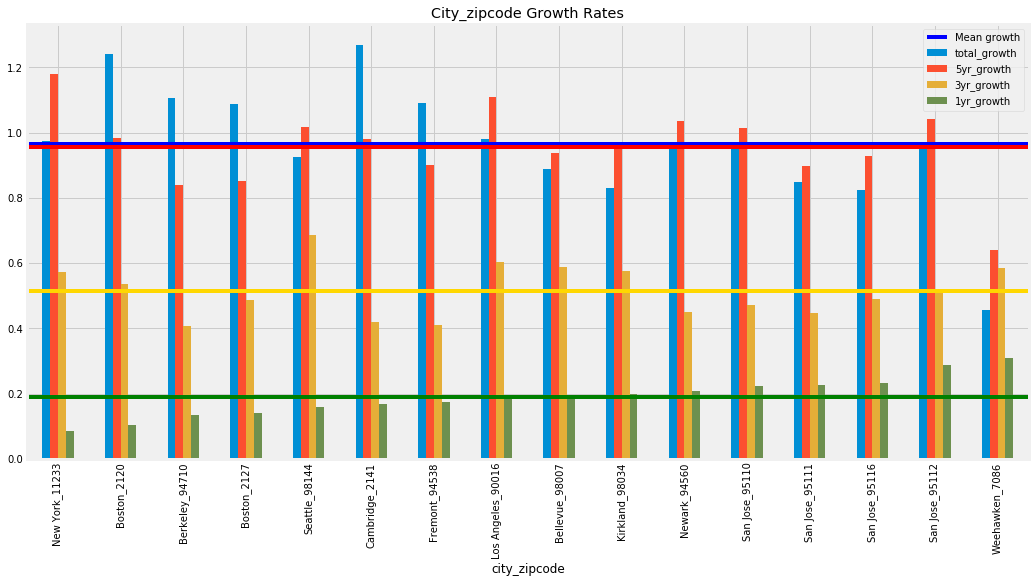

In [34]:
stacked_growth(top_high_cities)

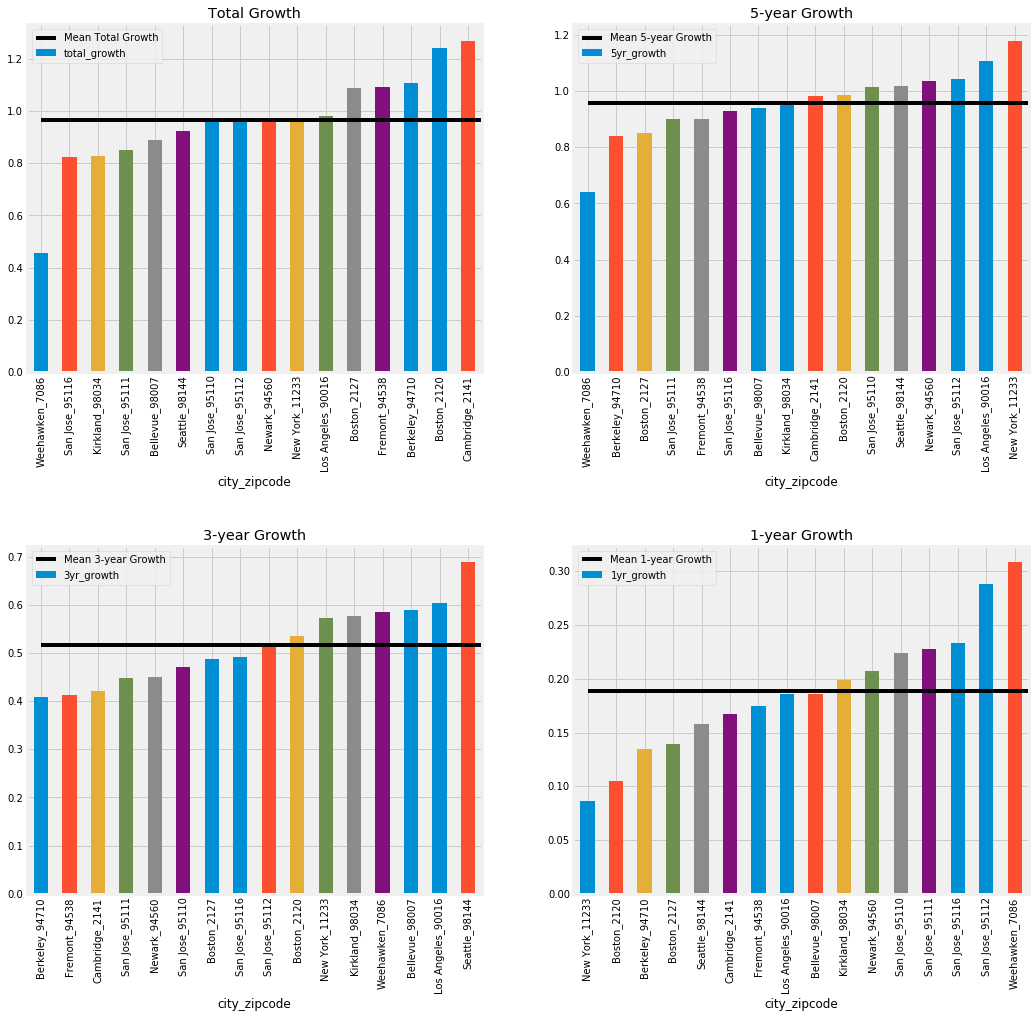

In [35]:
graph_growth(top_high_cities)

In [36]:
top_high_ts = get_time_series(top_high_cities)
top_high_ts['New York_11233'].head()

,city_zipcode,State,Metro,CountyName,value,YoY_change,YoY_rate_change
time,,,,,,,
2009-01-01,New York_11233,NY,New York,Kings,431700.0,NaN,NaN
2009-02-01,New York_11233,NY,New York,Kings,423100.0,NaN,NaN
2009-03-01,New York_11233,NY,New York,Kings,416900.0,NaN,NaN
2009-04-01,New York_11233,NY,New York,Kings,413100.0,NaN,NaN
2009-05-01,New York_11233,NY,New York,Kings,408300.0,NaN,NaN


In [37]:
# plot_time_series(top_high_ts, 'value')

In [38]:
# plot_time_series(top_high_ts, 'YoY_change')

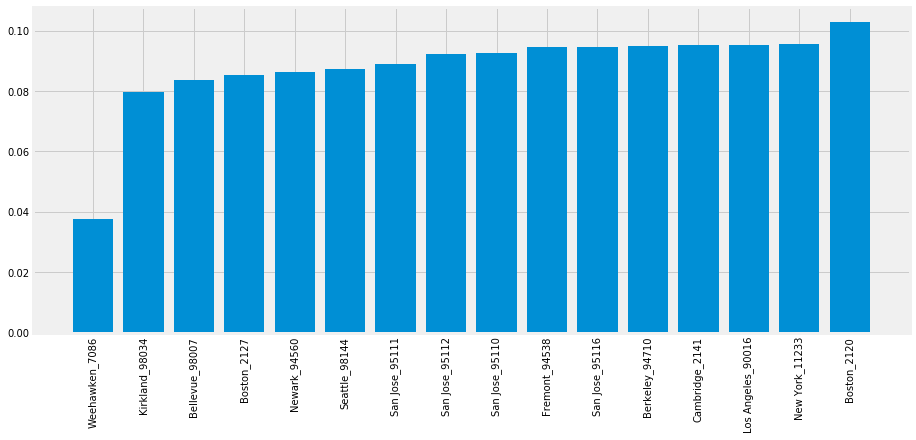

In [39]:
plot_avg_YoY(top_high_ts)

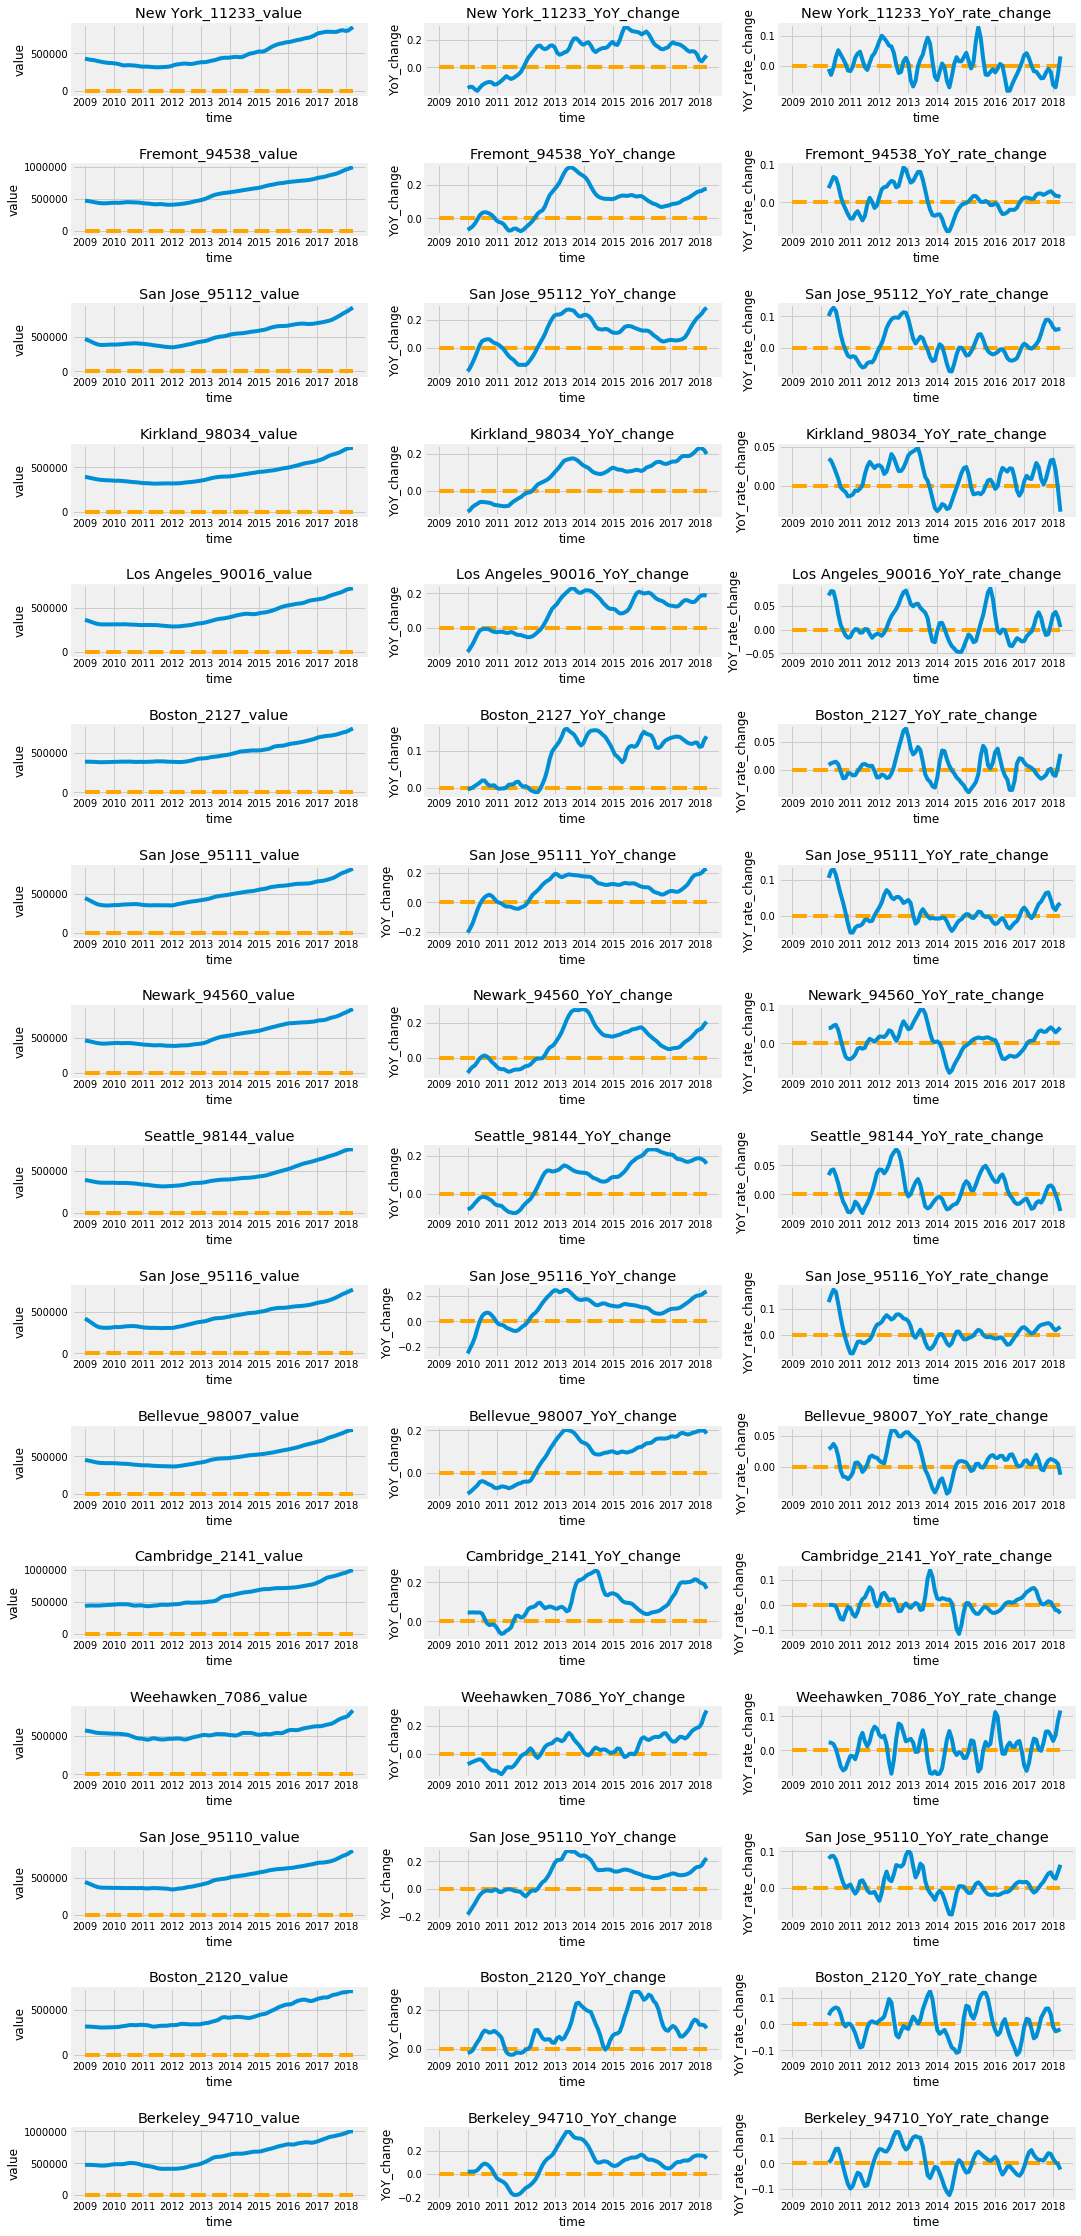

In [40]:
plot_time_series2(top_high_ts)

**Selections for modeling:**
* San Jose_95116 - steady upward growth
* Weehawken_7086 - accelerating recent growth

**Pull data out for analysis**

In [41]:
sj_ts = top_high_ts['San Jose_95116']['value']
wh_ts = top_high_ts['Weehawken_7086']['value']
display(sj_ts.head(3), wh_ts.head(3))

time
2009-01-01    418800.0
2009-02-01    400700.0
2009-03-01    381500.0
Name: value, dtype: float64

time
2009-01-01    574300.0
2009-02-01    569100.0
2009-03-01    564400.0
Name: value, dtype: float64

### Medium Cost City Analysis

In [42]:
top_med_cities = top_growth_cities(med_cost_zipcodes)
print('Cities in our list: ', len(top_med_cities))
top_med_cities.city_zipcode

Cities in our list:  18


319            Union City_7087
660           Jersey City_7306
1379             Oakland_94605
1477             Oakland_94601
1681             Oakland_94606
1737          Jersey City_7307
1843              Denver_80205
1853            Richmond_94804
3096            Lakewood_80214
4058           Somerville_2145
4070             Seattle_98106
4678          Charleston_29403
5217              Denver_80207
5436             Seattle_98108
7354            Richmond_94805
13591          El Portal_95389
13708    Mountain Center_92561
14636          Tuftonboro_3853
Name: city_zipcode, dtype: object

<Figure size 1872x576 with 0 Axes>

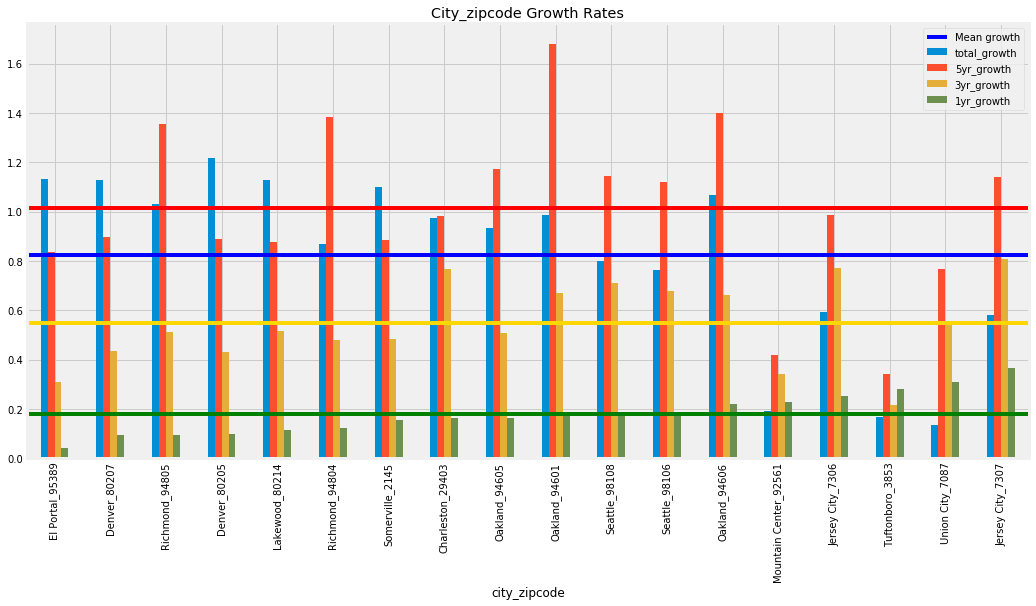

In [43]:
stacked_growth(top_med_cities)

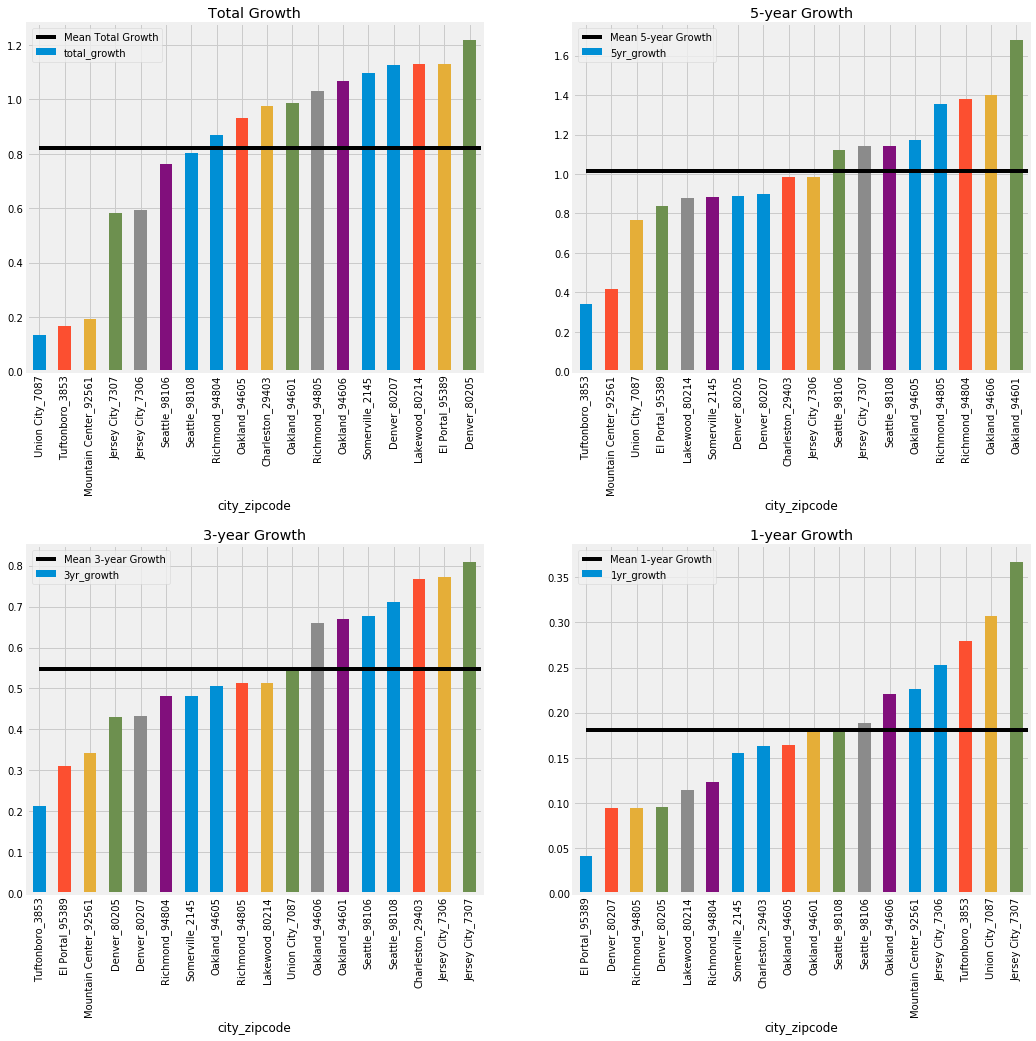

In [44]:
graph_growth(top_med_cities)

In [45]:
top_med_ts = get_time_series(top_med_cities)
top_med_ts['Union City_7087'].head(13)

,city_zipcode,State,Metro,CountyName,value,YoY_change,YoY_rate_change
time,,,,,,,
2009-01-01,Union City_7087,NJ,New York,Hudson,396300.0,NaN,NaN
2009-02-01,Union City_7087,NJ,New York,Hudson,386000.0,NaN,NaN
2009-03-01,Union City_7087,NJ,New York,Hudson,375900.0,NaN,NaN
2009-04-01,Union City_7087,NJ,New York,Hudson,366300.0,NaN,NaN
2009-05-01,Union City_7087,NJ,New York,Hudson,356200.0,NaN,NaN
2009-06-01,Union City_7087,NJ,New York,Hudson,345600.0,NaN,NaN
2009-07-01,Union City_7087,NJ,New York,Hudson,335900.0,NaN,NaN
2009-08-01,Union City_7087,NJ,New York,Hudson,327500.0,NaN,NaN
2009-09-01,Union City_7087,NJ,New York,Hudson,320800.0,NaN,NaN


In [46]:
# plot_time_series(top_med_ts, 'value')

In [47]:
# plot_time_series(top_med_ts, 'YoY_change')

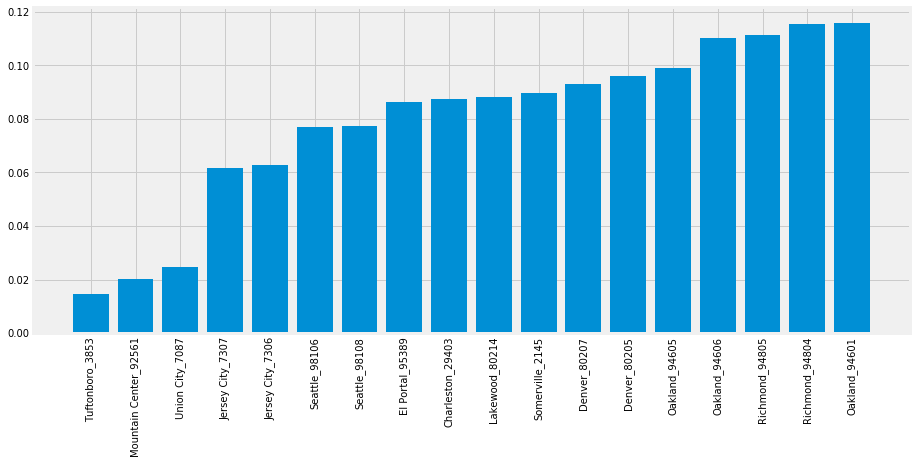

In [48]:
plot_avg_YoY(top_med_ts)

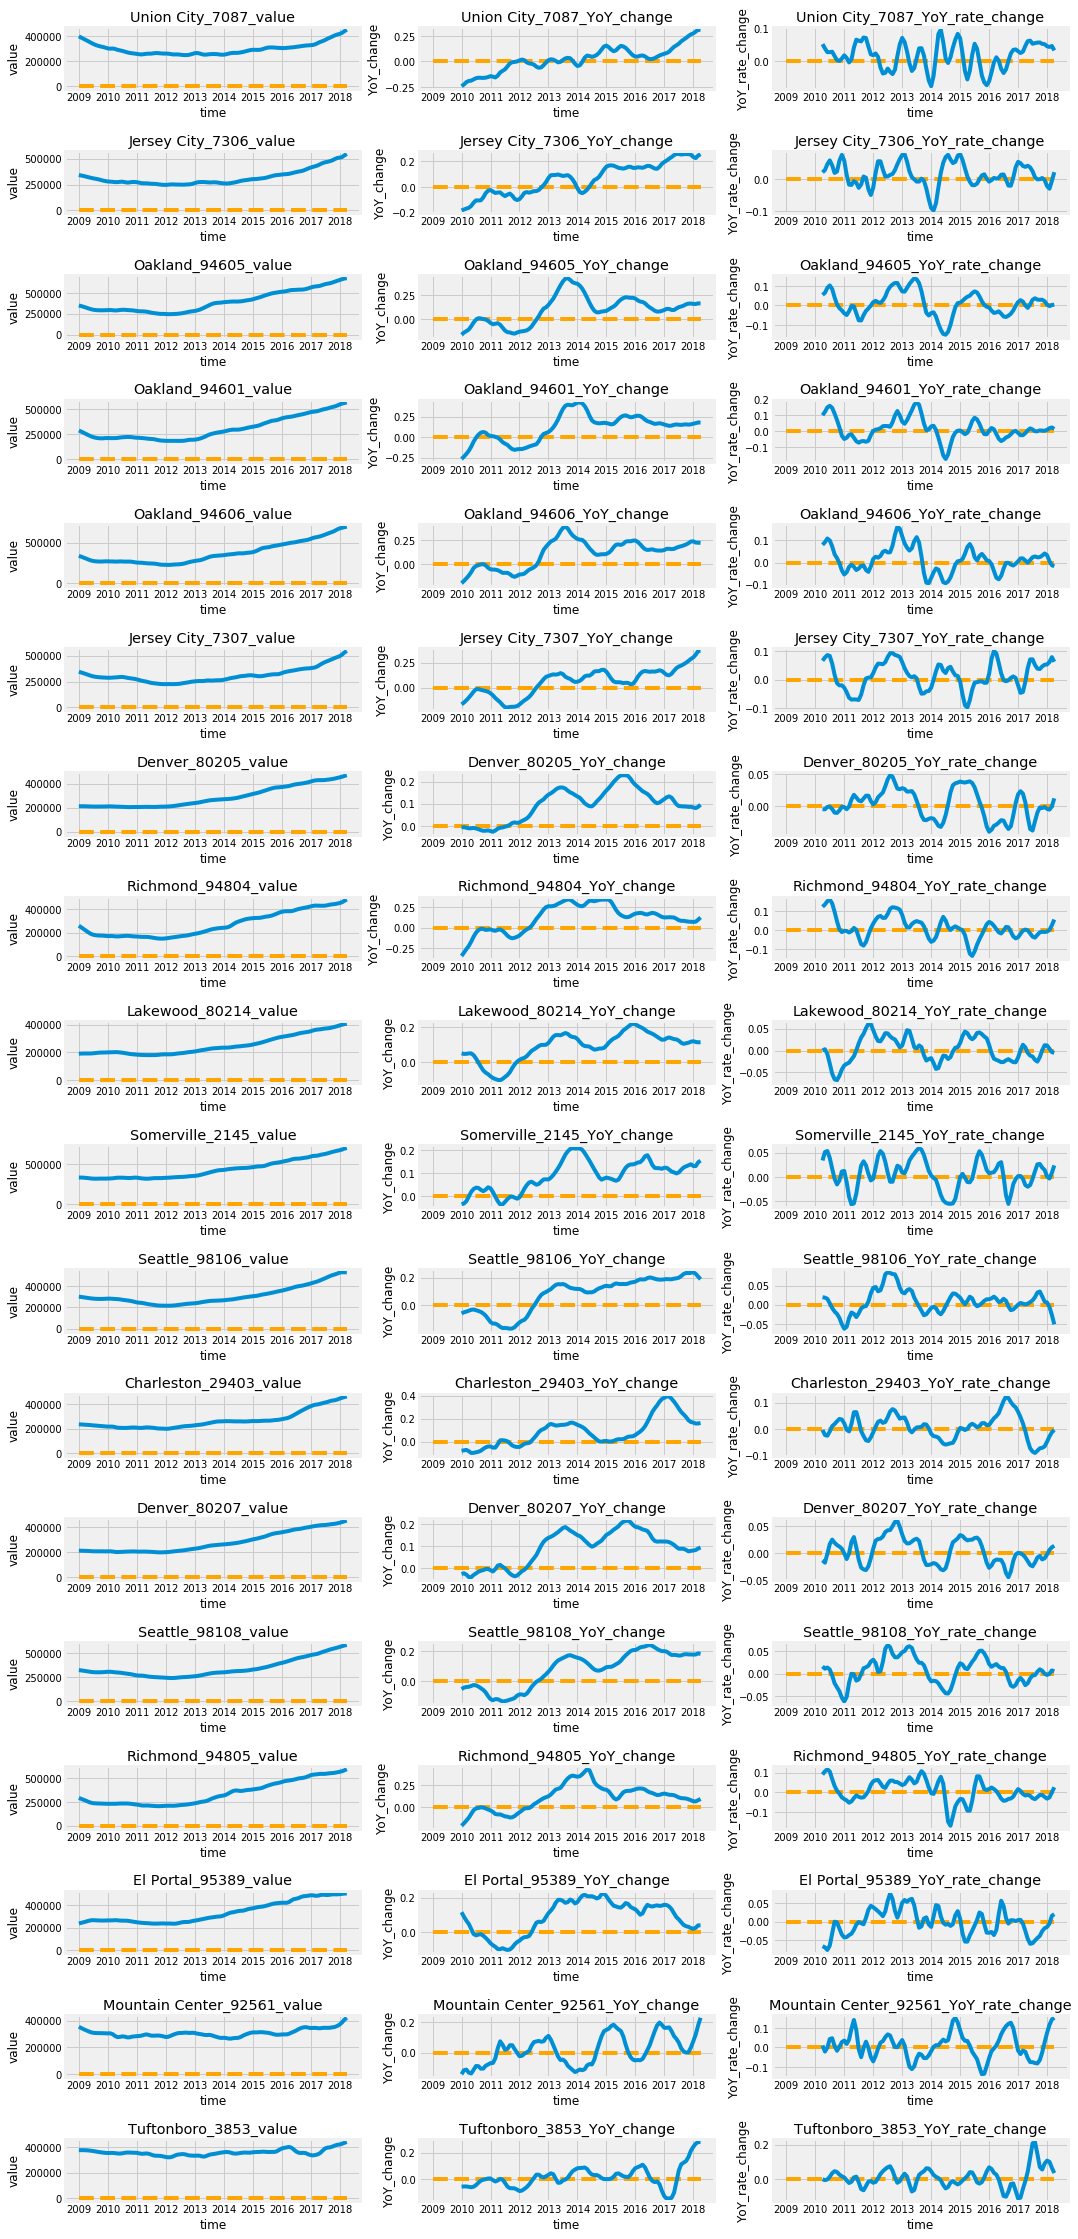

In [49]:
plot_time_series2(top_med_ts)

For medium cost properties I choose: 
- Union City_7087
- Jersey City_7306
- Oakland_64601

In [50]:
uc_ts = top_med_ts['Union City_7087']
jc_ts = top_med_ts['Jersey City_7306']
ok_ts = top_med_ts['Oakland_94601']

### Low City Cost Analysis 

In [51]:
top_low_cities = top_growth_cities(low_cost_zipcodes)
print('Cities in our list: ', len(top_low_cities))
top_low_cities.city_zipcode

Cities in our list:  19


466         Philadelphia_19134
610               Denver_80219
1239             Vallejo_94590
1821           Charlotte_28208
2155              Denver_80204
2347        Jacksonville_32205
2452           Williston_58801
2470              Aurora_80010
2627          Lake Worth_33460
2661    Saint Petersburg_33705
3188            Palm Bay_32905
3285             Reading_19601
3464               Orange_7050
3540               Newark_7103
4211               Newark_7106
5830             Redford_48240
6105           Nashville_37210
6563          Pittsburgh_15201
6896            Wildwood_34785
Name: city_zipcode, dtype: object

<Figure size 1872x576 with 0 Axes>

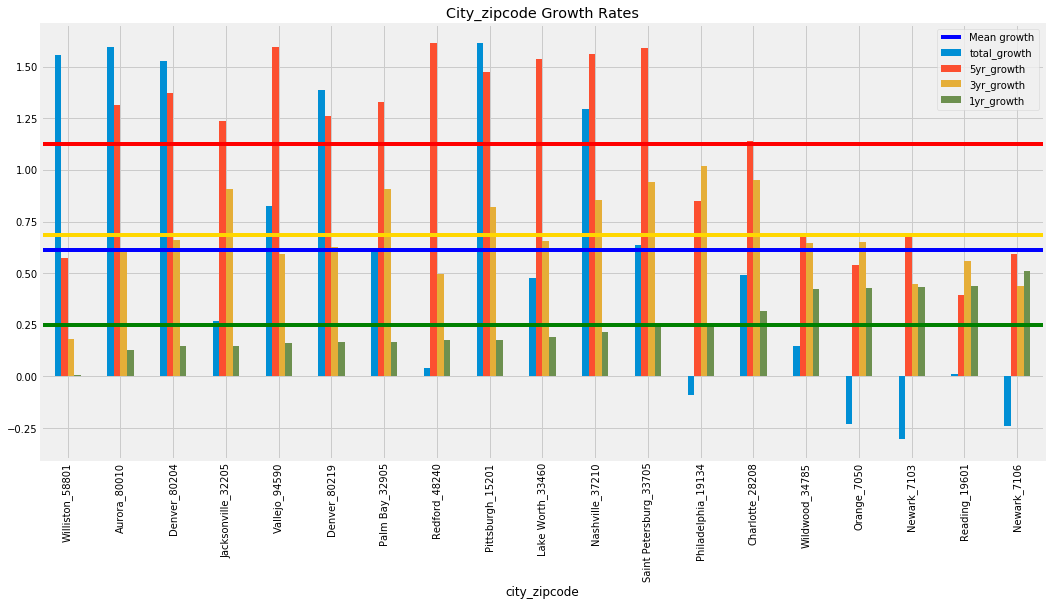

In [52]:
stacked_growth(top_low_cities)

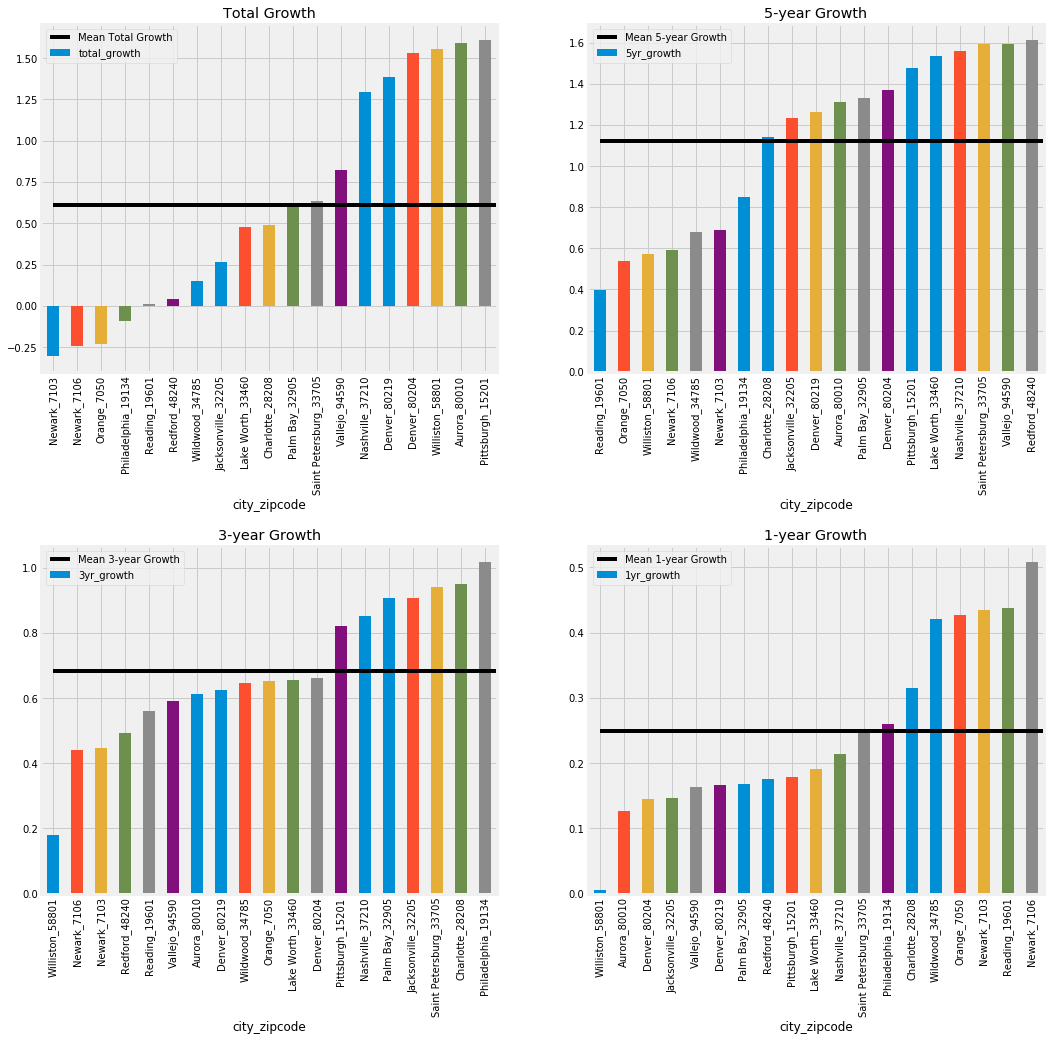

In [53]:
graph_growth(top_low_cities)

In [54]:
top_low_ts = get_time_series(top_low_cities)
top_low_ts['Philadelphia_19134'].head(13)

,city_zipcode,State,Metro,CountyName,value,YoY_change,YoY_rate_change
time,,,,,,,
2009-01-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,51100.0,NaN,NaN
2009-02-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,50400.0,NaN,NaN
2009-03-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,49900.0,NaN,NaN
2009-04-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,49500.0,NaN,NaN
2009-05-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,48800.0,NaN,NaN
2009-06-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,48100.0,NaN,NaN
2009-07-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,47200.0,NaN,NaN
2009-08-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,46500.0,NaN,NaN
2009-09-01,Philadelphia_19134,PA,Philadelphia,Philadelphia,46100.0,NaN,NaN


In [55]:
# plot_time_series(top_low_ts, 'value')

In [56]:
# plot_time_series(top_low_ts, 'YoY_change')

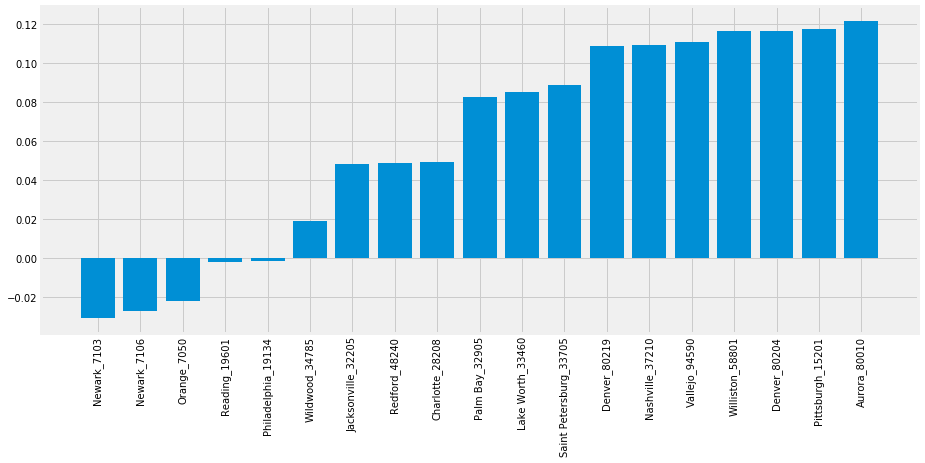

In [57]:
plot_avg_YoY(top_low_ts)

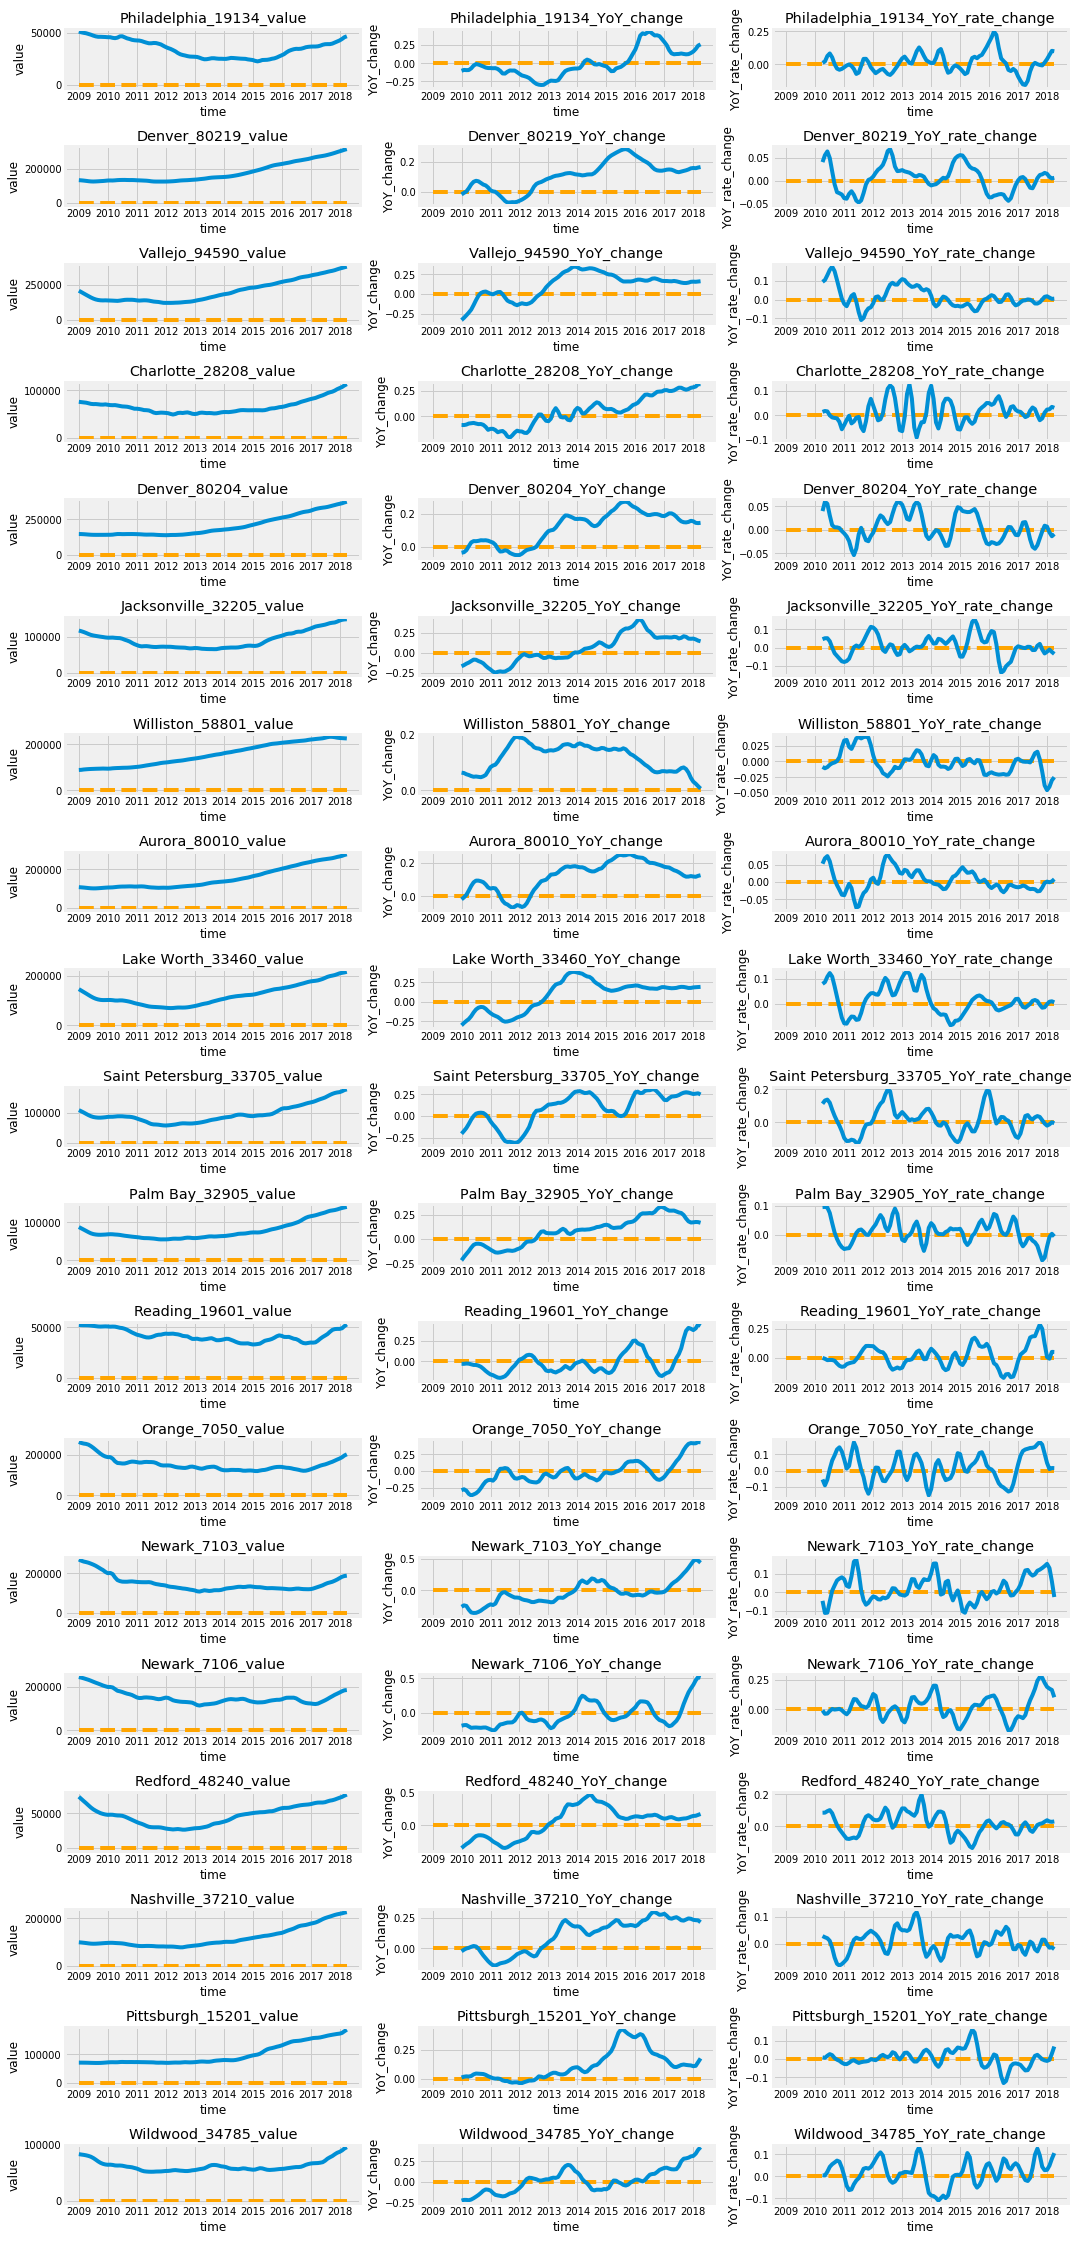

In [58]:
plot_time_series2(top_low_ts)

I choose: 
- Vallejo
- Aurora
- Lake Worth

In [59]:
va_ts = top_low_ts['Vallejo_94590']
au_ts = top_low_ts['Aurora_80010']
lw_ts = top_low_ts['Lake Worth_33460']

# Modeling

## High Cost Models

### Stationarity check

Rolling statistics

In [60]:
def rolling_stats(ts, title=None):
    roll_mean = ts.rolling(window=12, center=False).mean()
    roll_std = ts.rolling(window=12, center=False).std()
    
    fig = plt.figure(figsize=(12,4))
    orig = plt.plot(ts, color='blue', label='Value')
    mean = plt.plot(roll_mean, color='orange', label='Rolling Mean')
    std = plt.plot (roll_std, color='green', label='Rolling Std')
    plt.legend(loc='best')
    plt.title(title + ' ' + 'Rolling Mean & Standard Deviation')
    plt.show()
    
def subtract_rollmean(ts, window=12):
    roll_mean = ts.rolling(window=window).mean()
    ts_minus_rollmean = ts - roll_mean
    
    return ts_minus_rollmean
    
def subtract_w_rollmean(ts, halflife=4):
    w_roll_mean = ts.ewm(halflife=halflife).mean()
    ts_minus_w_rollmean =  ts - w_roll_mean
    
    return ts_minus_w_rollmean

def adf_test(ts):
    
    ts = ts.dropna()
    
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts)

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
def stationarity_check(ts, title=None):
    rolling_stats(ts, title=title)
    adf_test(ts)

In [61]:
def ts_transformer(ts):
    '''takes a time series and iterates through a number of transformation techniques
       and applies the adfuller test to identify the lowest possible p-value for stationarity'''
    
    p_values = []

    org = ts
    log = np.log(ts)
    sqrt = np.sqrt(ts)
    
    base_transforms = [org, log, sqrt]
    roll_periods = [3, 6, 8, 12]
    half_lifes = [1, 2, 3, 4]
    
    for v in base_transforms:
        adf = adfuller(v)[1]
        p_values.append(adf)
    
        v_diff = v.diff(periods=1) 
        adf_diff = adfuller(v_diff.dropna())[1]
        p_values.append(adf_diff)
        
        for i in roll_periods:
            roll_minus = subtract_rollmean(v, window=i)
            adf_roll_minus = adfuller(roll_minus.dropna())[1]
            p_values.append(adf_roll_minus)
            
            roll_minus_diff = roll_minus.diff(periods=1)
            adf_roll_minus_diff = adfuller(roll_minus.dropna())[1]
            p_values.append(adf_roll_minus_diff)
        
        for h in half_lifes:
            w_roll_minus = subtract_w_rollmean(v, halflife=h)
            adf_w_roll_minus = adfuller(w_roll_minus.dropna())[1]
            p_values.append(adf_w_roll_minus)
            
            w_roll_minus_diff = w_roll_minus.diff(periods=1)
            adf_w_roll_minus_diff = adfuller(w_roll_minus_diff.dropna())[1]
            p_values.append(adf_w_roll_minus_diff)
        
        
    return p_values
      

In [62]:
def stationarity_transformer(ts, alpha=.05, transform=None):
    '''takes a time series and iterates through a number of transformation techniques
       and applies the adfuller test to identify the lowest possible p-value for stationarity'''
    
    p_values = []
    
    roll_periods = [3, 6, 8, 12]
    half_lifes = [1, 2, 3, 4]
    
    alpha = .05
    
    v = ts
    name = 'Original'
    
    if transform == 'log':
        v = np.log(ts)
        name = 'Log' 
    elif transform == 'sqrt':
        v = np.sqrt(ts)
        name = 'Sqrt'
    else:
        None

    # Original data
    adf = adfuller(v)[1]
    if adf <= alpha:
        p_values.append((name , adf))
    
    v_diff = v.diff(periods=1) 
    adf_diff = adfuller(v_diff.dropna())[1]
    if adf <= alpha:
        p_values.append((name + 'diff: ', adf_diff))

    for i in roll_periods:
        iteration_name = name + '_minus_roll_mean_' + str(i) +':'
        roll_minus = subtract_rollmean(v, window=i)
        adf_roll_minus = adfuller(roll_minus.dropna())[1]
        if adf_roll_minus <= alpha:
            p_values.append((iteration_name, adf_roll_minus))
         
    for i in roll_periods:
        iteration_name = name + '_minus_roll_mean_diff_' + str(i) +':'
        roll_minus = subtract_rollmean(v, window=i)
        roll_minus_diff = roll_minus.diff(periods=1)
        adf_roll_minus_diff = adfuller(roll_minus.dropna())[1]
        if adf_roll_minus_diff <= alpha:
            p_values.append((iteration_name, adf_roll_minus_diff))
    
    for h in half_lifes:
        interation_name = name + '_minus_w_roll_mean_' + str(h) + ':'
        w_roll_minus = subtract_w_rollmean(v, halflife=h)
        adf_w_roll_minus = adfuller(w_roll_minus.dropna())[1]
        if adf_w_roll_minus <= alpha:
            p_values.append((iteration_name, adf_w_roll_minus))
  
    for h in half_lifes:
        iteration_name = name + '_minus_w_roll_mean_diff_' + str(h) + ':'
        w_roll_minus = subtract_w_rollmean(v, halflife=h)
        w_roll_minus_diff = w_roll_minus.diff(periods=1)
        adf_w_roll_minus_diff = adfuller(w_roll_minus_diff.dropna())[1]
        if adf_w_roll_minus_diff <= alpha:
            p_values.append((iteration_name, adf_w_roll_minus_diff))
        
    return p_values
      

In [63]:
def all_stationarity(ts):
    tests = [None, 'log', 'sqrt']
    
    for t in tests:
        test = stationarity_transformer(ts, transform=t)
        display(test)

#### San Jose Analysis

Let's first check to the stationarity of our data to see if we can apply a model directly. 

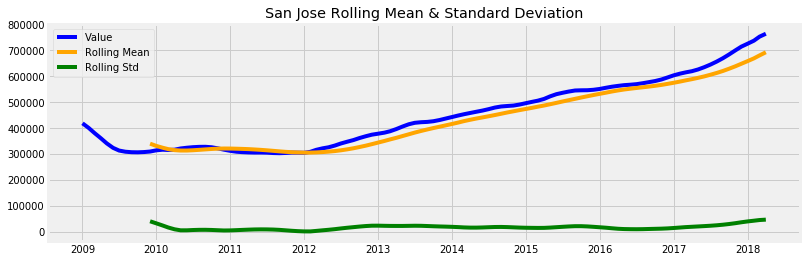

Results of Dickey-Fuller Test:
Test Statistic                   1.681359
p-value                          0.998082
#Lags Used                       9.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [64]:
stationarity_check(sj_ts, title='San Jose')

**Observations:** It looks like our data is not quite stationary, the mean increases over time and the adfuller p-value is very high.

Let's see if there are some transformations we can do to make our data more stationary. 

In [65]:
all_stationarity(sj_ts)

[('Original_minus_roll_mean_3:', 0.011906995783480336),
 ('Original_minus_roll_mean_diff_3:', 0.011906995783480336),
 ('Original_minus_w_roll_mean_diff_1:', 0.0010985119914647705),
 ('Original_minus_w_roll_mean_diff_2:', 0.0018571066453465187),
 ('Original_minus_w_roll_mean_diff_3:', 0.0031490884462736838),
 ('Original_minus_w_roll_mean_diff_4:', 0.0050434778053620845)]

[('Log_minus_w_roll_mean_diff_1:', 0.0005513808944027823),
 ('Log_minus_w_roll_mean_diff_2:', 0.000884196526851861),
 ('Log_minus_w_roll_mean_diff_3:', 0.001514717051850286),
 ('Log_minus_w_roll_mean_diff_4:', 0.0025366429429752872)]

[('Sqrt_minus_w_roll_mean_diff_1:', 0.0006960782074679233),
 ('Sqrt_minus_w_roll_mean_diff_2:', 0.0011436876371370313),
 ('Sqrt_minus_w_roll_mean_diff_3:', 0.001937833808796243),
 ('Sqrt_minus_w_roll_mean_diff_4:', 0.003157323443438213)]

It looks like there are a number of ways we could transform the data. To preserve the original data as much as possible we can start with simpler transformations and try a few more increasingly complex methods. 

In [66]:
sj_roll_3 = subtract_rollmean(ts=sj_ts, window=3).dropna()
sj_log_w_roll_2_diff = subtract_w_rollmean(ts=np.log(sj_ts), halflife=2).diff().dropna()
sj_sqrt_w_roll_2_diff = subtract_w_rollmean(ts=np.sqrt(sj_ts), halflife=2).diff().dropna()

sj_series = [sj_ts, sj_roll_3, sj_log_w_roll_2_diff, sj_sqrt_w_roll_2_diff]

Let's see how these look.

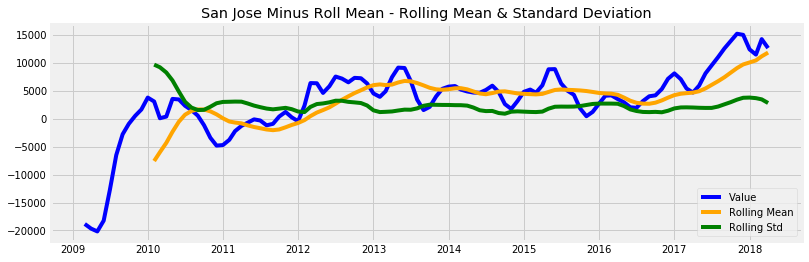

Results of Dickey-Fuller Test:
Test Statistic                  -3.373203
p-value                          0.011907
#Lags Used                       4.000000
Number of Observations Used    105.000000
Critical Value (1%)             -3.494220
Critical Value (5%)             -2.889485
Critical Value (10%)            -2.581676
dtype: float64


In [67]:
stationarity_check(sj_roll_3, title='San Jose Minus Roll Mean -')

**Observations:** Mean increasing, std fairly flat, not stationary

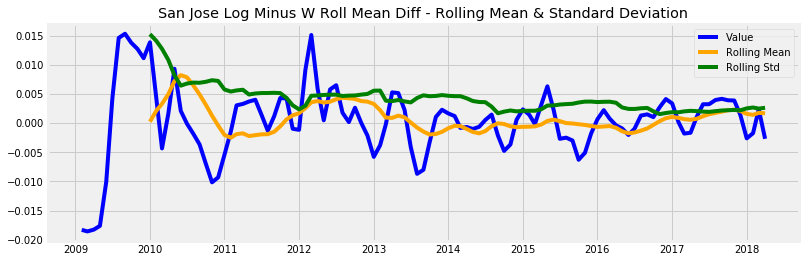

Results of Dickey-Fuller Test:
Test Statistic                  -4.123865
p-value                          0.000884
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [68]:
stationarity_check(ts=sj_log_w_roll_2_diff, title='San Jose Log Minus W Roll Mean Diff -')

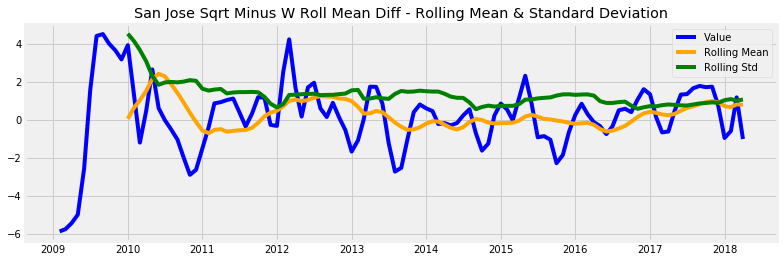

Results of Dickey-Fuller Test:
Test Statistic                  -4.056086
p-value                          0.001144
#Lags Used                       8.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [69]:
stationarity_check(ts=sj_sqrt_w_roll_2_diff, title='San Jose Sqrt Minus W Roll Mean Diff -')

### ACF and PACF

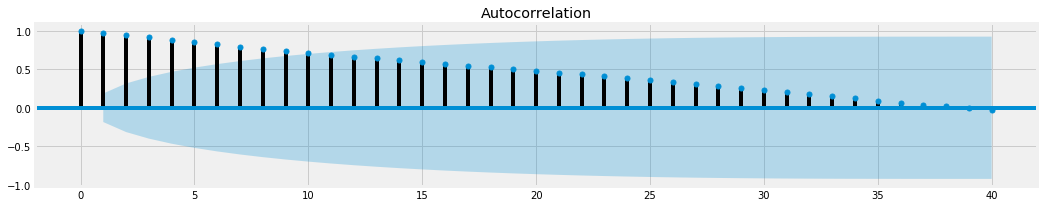

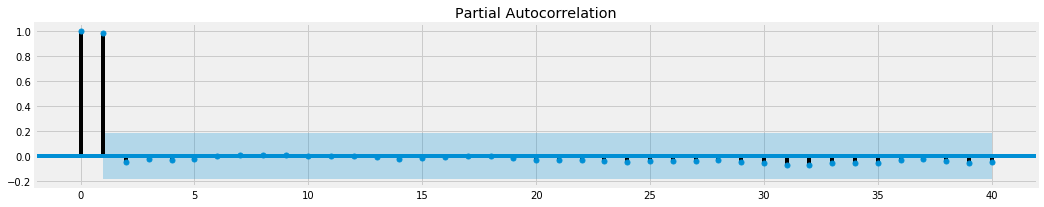

In [70]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


fig, ax = plt.subplots(figsize=(16,3))
plot_acf(sj_ts.dropna(),ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(sj_ts.dropna(),ax=ax, lags=40);

### SARIMA

In [71]:
def SARIMA_iterator(ts, order=2):

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, order)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
#                 print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
            except:
                continue
            
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    display(ans_df.loc[ans_df['aic'].idxmin()])

In [72]:
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(sj_log_w_roll_2_diff,
                                         order =(1,0,1),
                                         seasonal_order=(0,0,0,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6271      0.057     11.009      0.000       0.515       0.739
ma.L1          0.6677      0.074      9.022      0.000       0.523       0.813
sigma2      8.362e-06   9.74e-07      8.581      0.000    6.45e-06    1.03e-05


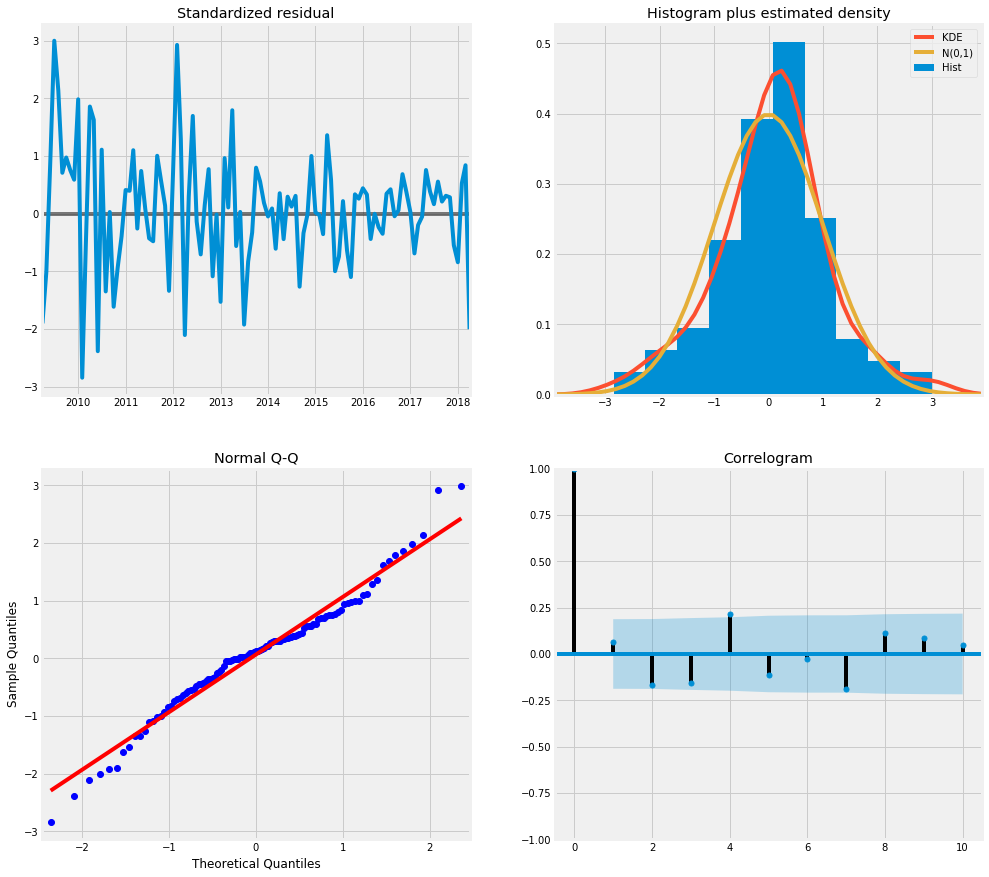

In [73]:
output.plot_diagnostics(figsize=(15,15));

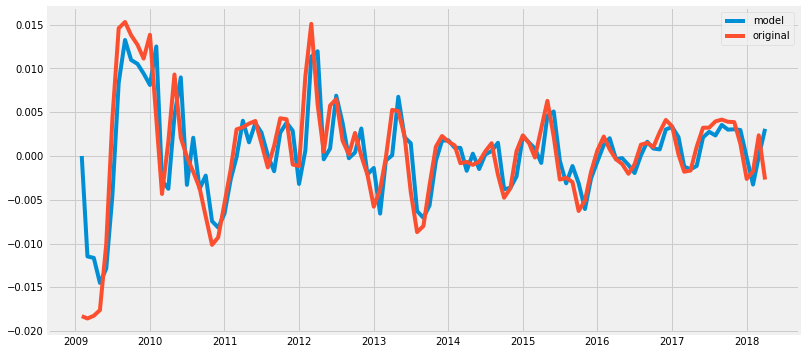

In [74]:
fig = plt.figure(figsize=(12,6))

plt.plot(output.predict(), label='model')
plt.plot(sj_log_w_roll_2_diff, label='original')
plt.legend()

In [75]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.01)


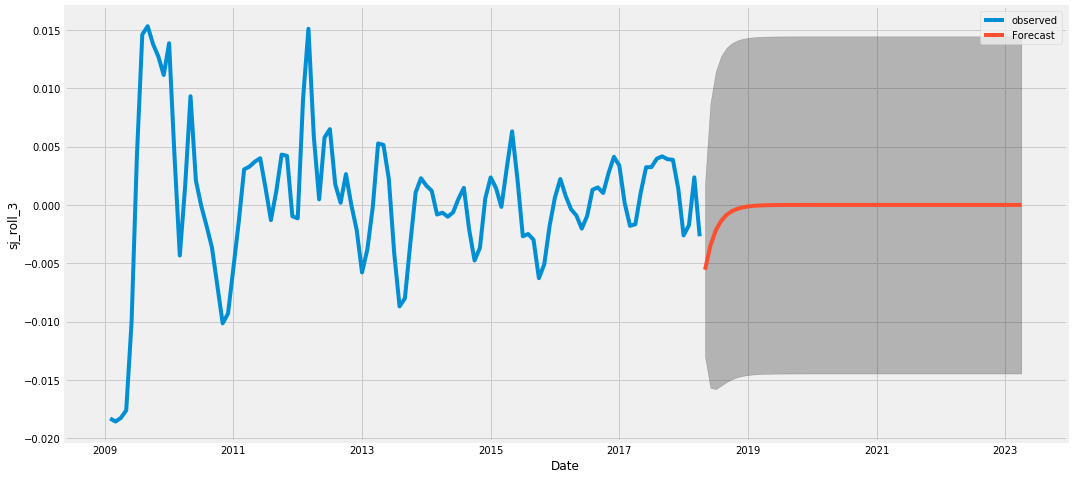

In [76]:
ax = sj_log_w_roll_2_diff.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('sj_roll_3')

plt.legend()
plt.show()

SJ Model 3

In [77]:
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(sj_ts,
                                         order= (0,1,0),
                                         seasonal_order= (1,0,1,0),
                                         trend= 'ct',
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
output = SARIMA_MODEL.fit()

display(output.params, output.pvalues, output.aic)

intercept   -4.782195e+03
drift        1.409659e+02
ar.S.L1     -3.214271e-02
ma.S.L1      9.049844e-01
sigma2       2.202924e+07
dtype: float64

intercept    6.150089e-02
drift        2.256312e-03
ar.S.L1      5.080851e-03
ma.S.L1      9.612291e-07
sigma2       0.000000e+00
dtype: float64

2083.7640100105664

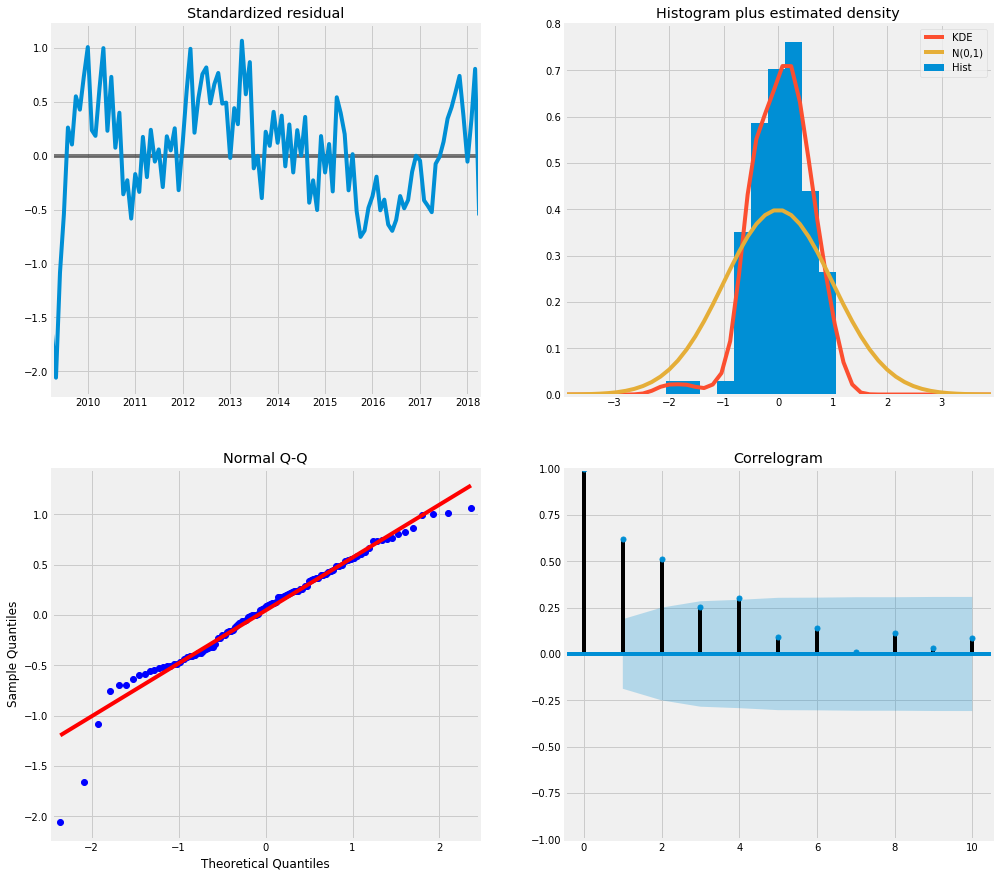

In [78]:
output.plot_diagnostics(figsize=(15,15));

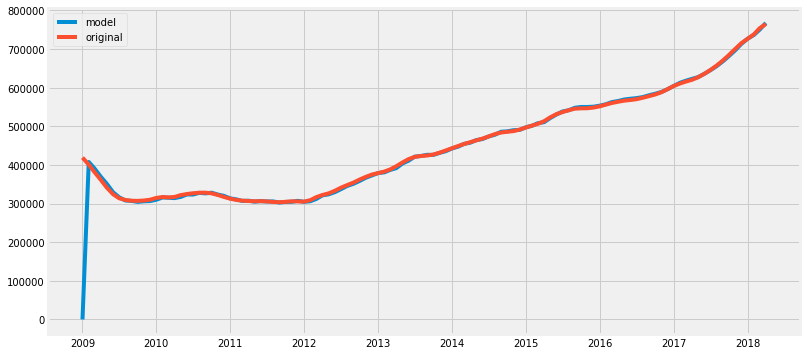

In [79]:
fig = plt.figure(figsize=(12,6))

plt.plot(output.predict(), label='model')
plt.plot(sj_ts, label='original')
plt.legend()

In [80]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.01)

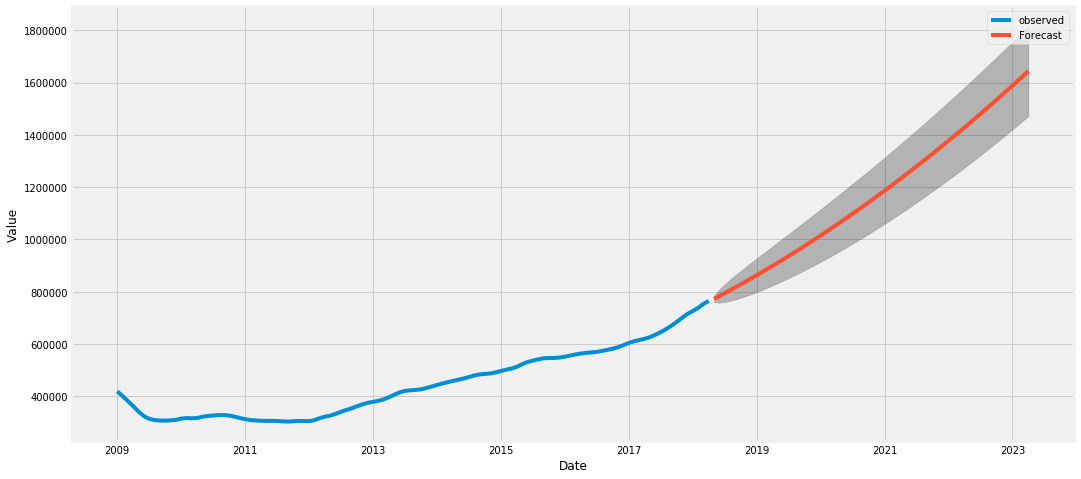

In [81]:
ax = sj_ts.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()

#### Weehawken Analysis

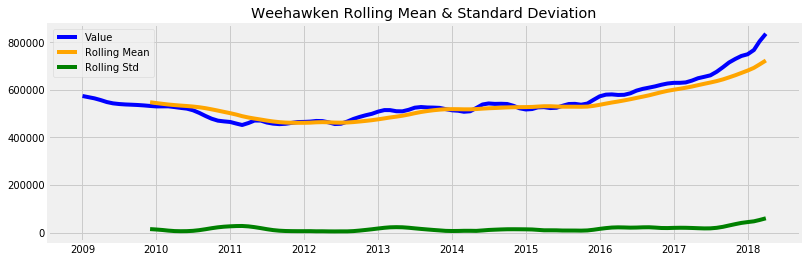

Results of Dickey-Fuller Test:
Test Statistic                   1.659369
p-value                          0.998025
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64


In [82]:
#stationarity check
stationarity_check(wh_ts, title='Weehawken')

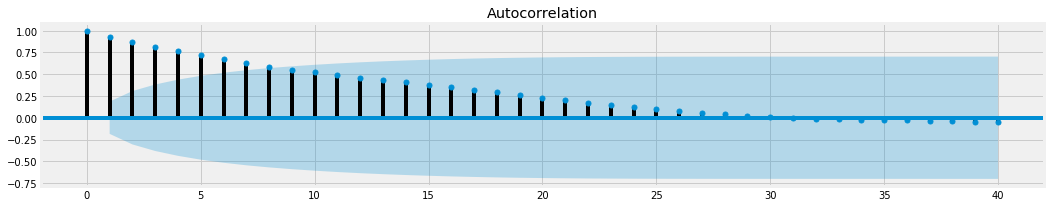

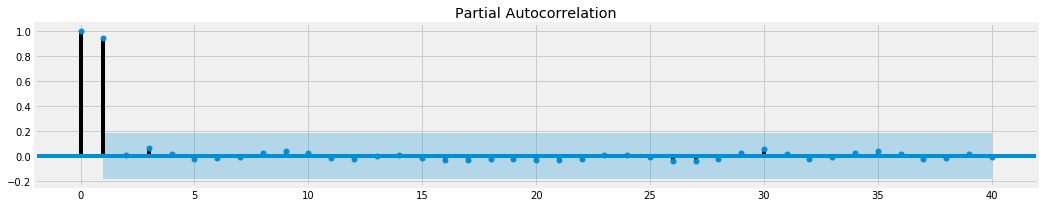

In [83]:
# ACF and PACF

fig, ax = plt.subplots(figsize=(16,3))
plot_acf(wh_ts.dropna(),ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(wh_ts.dropna(),ax=ax, lags=40);

In [84]:
SARIMA_iterator(wh_ts)

pdq         (1, 1, 1)
pdqs    (0, 1, 1, 12)
aic           1728.16
Name: 59, dtype: object

In [85]:
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(wh_ts,
                                         order =(1,1,1),
                                         seasonal_order=(0,1,1,12),
                                         trend= 'ct',
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -620.4098   4785.250     -0.130      0.897   -9999.328    8758.508
drift         36.7558     62.583      0.587      0.557     -85.904     159.416
ar.L1          0.4405      0.157      2.802      0.005       0.132       0.749
ma.L1          1.2937      0.087     14.887      0.000       1.123       1.464
ma.S.L12       0.0662      0.040      1.643      0.100      -0.013       0.145
sigma2      2.478e+07      1.207   2.05e+07      0.000    2.48e+07    2.48e+07


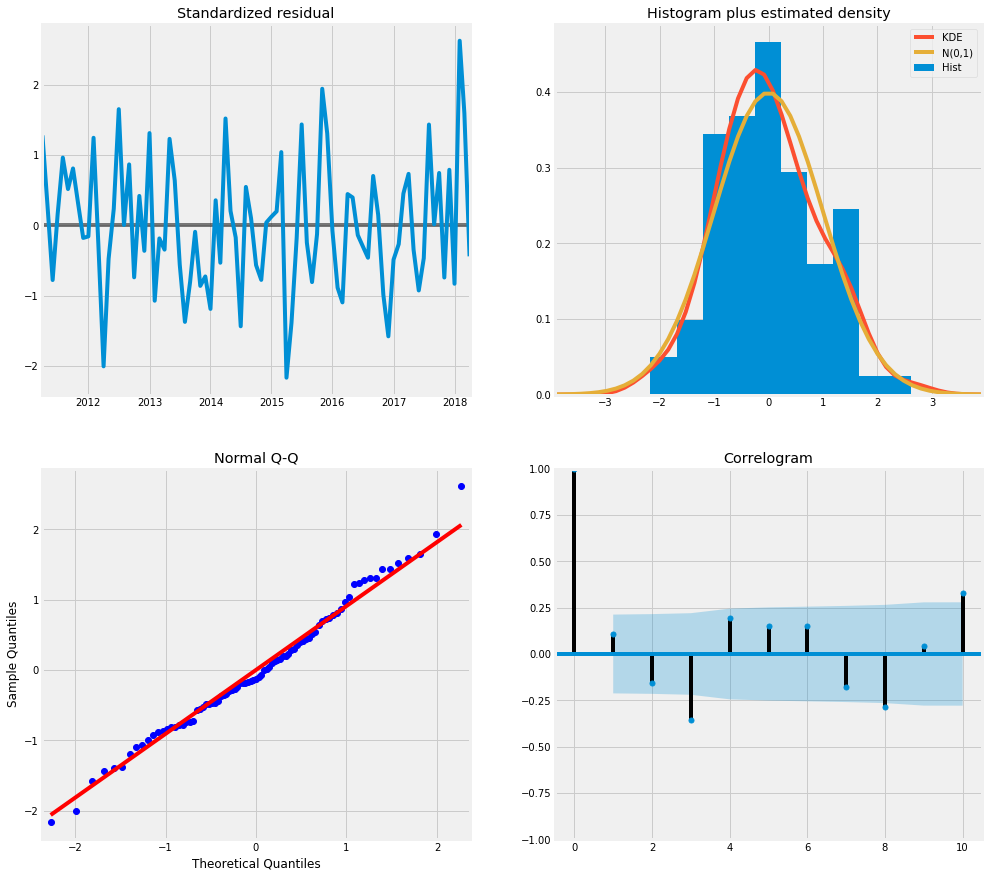

In [86]:
output.plot_diagnostics(figsize=(15,15));

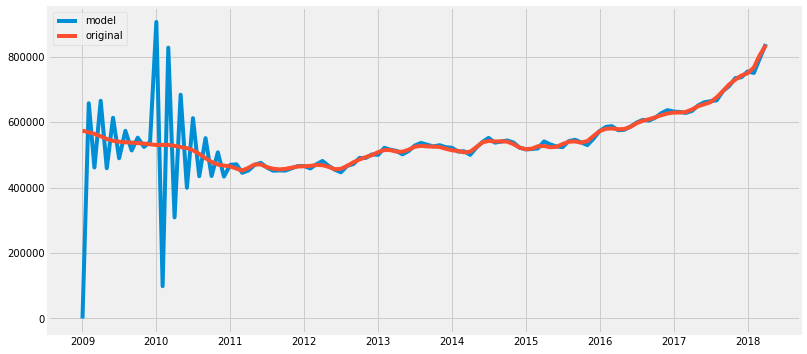

In [87]:
fig = plt.figure(figsize=(12,6))

plt.plot(output.predict(), label='model')
plt.plot(wh_ts, label='original')
plt.legend()

In [88]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.01)


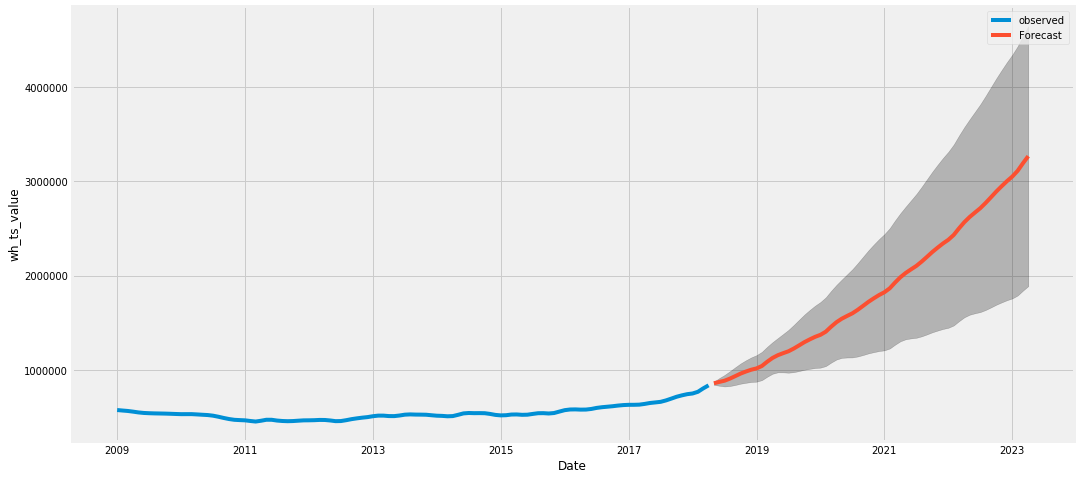

In [89]:
ax = wh_ts.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('wh_ts_value')

plt.legend()
plt.show()

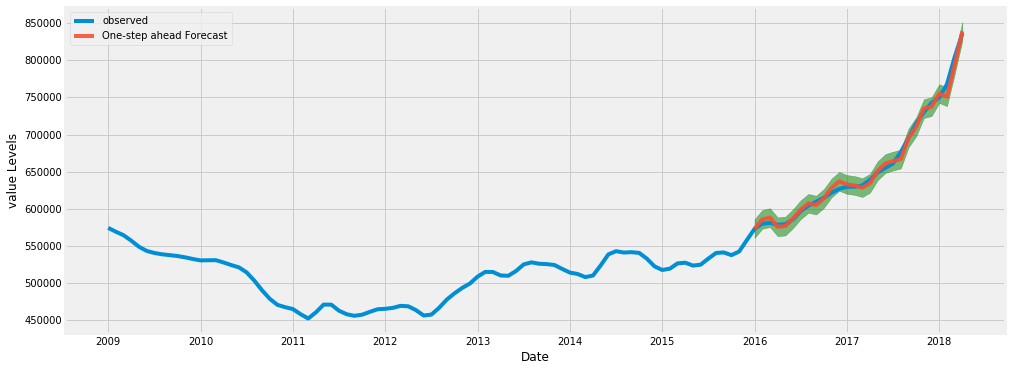

In [90]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = wh_ts.plot(label='observed')

#Plot predicted values
prediction = output.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = prediction.conf_int()

prediction.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('value Levels')
plt.legend()

plt.show()

In [91]:
SARIMA_MSE_Iterator(data=wh_ts, n_test=12, seasonal=[0,12])

[(0, 1, 2), (0, 0, 2, 12), 'ct'] 5694.436743718188
[(0, 1, 1), (0, 0, 2, 0), 't'] 5829.25737219155
[(0, 1, 2), (1, 0, 2, 12), 'ct'] 5927.629494634621


In [92]:
SARIMA_MSE_Iterator(data=wh_ts, n_test=24, seasonal=(0,12))

[(2, 1, 0), (1, 0, 0, 0), 'ct'] 4430.741800455374
[(1, 1, 0), (2, 0, 0, 0), 'ct'] 4485.296620763186
[(2, 1, 0), (2, 0, 1, 0), 'ct'] 4524.024186982534


## Medium Cost Models

In [93]:
uc_ts = uc_ts['value']
jc_ts = jc_ts['value']
ok_ts = ok_ts['value']

#### Union City

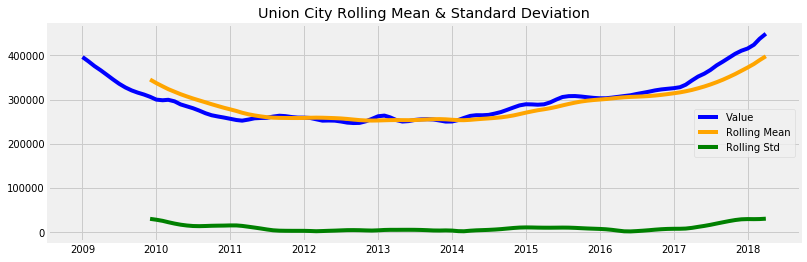

Results of Dickey-Fuller Test:
Test Statistic                   1.202163
p-value                          0.996001
#Lags Used                       9.000000
Number of Observations Used    102.000000
Critical Value (1%)             -3.496149
Critical Value (5%)             -2.890321
Critical Value (10%)            -2.582122
dtype: float64


In [94]:
stationarity_check(uc_ts, title='Union City')

Union City


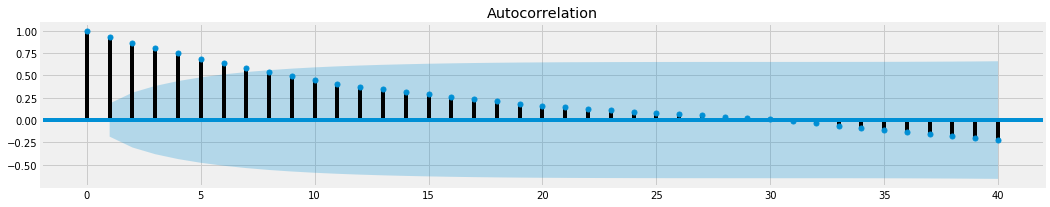

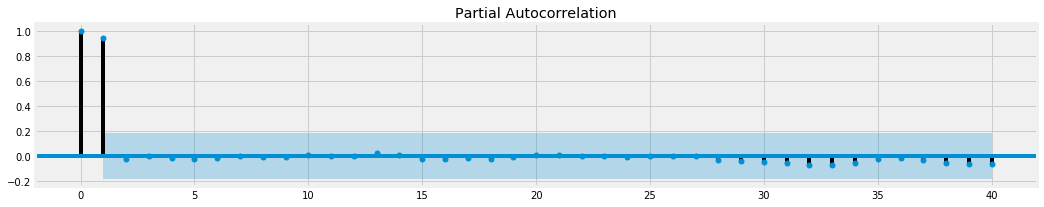

In [95]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(uc_ts.dropna(),ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(uc_ts.dropna(),ax=ax, lags=40);

print('Union City')

In [96]:
SARIMA_iterator(uc_ts)

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           1564.25
Name: 63, dtype: object

In [97]:
SARIMA_MODEL = sm.tsa.statespace.SARIMAX(uc_ts,
                                         order =(1,1,1),
                                         seasonal_order=(1,1,1,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)
output = SARIMA_MODEL.fit()

print(output.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6698      0.083      8.104      0.000       0.508       0.832
ma.L1          0.6636      0.092      7.177      0.000       0.482       0.845
ar.S.L12       0.1654      0.073      2.276      0.023       0.023       0.308
ma.S.L12      -0.2646      0.104     -2.535      0.011      -0.469      -0.060
sigma2      4.722e+06   3.39e-09   1.39e+15      0.000    4.72e+06    4.72e+06


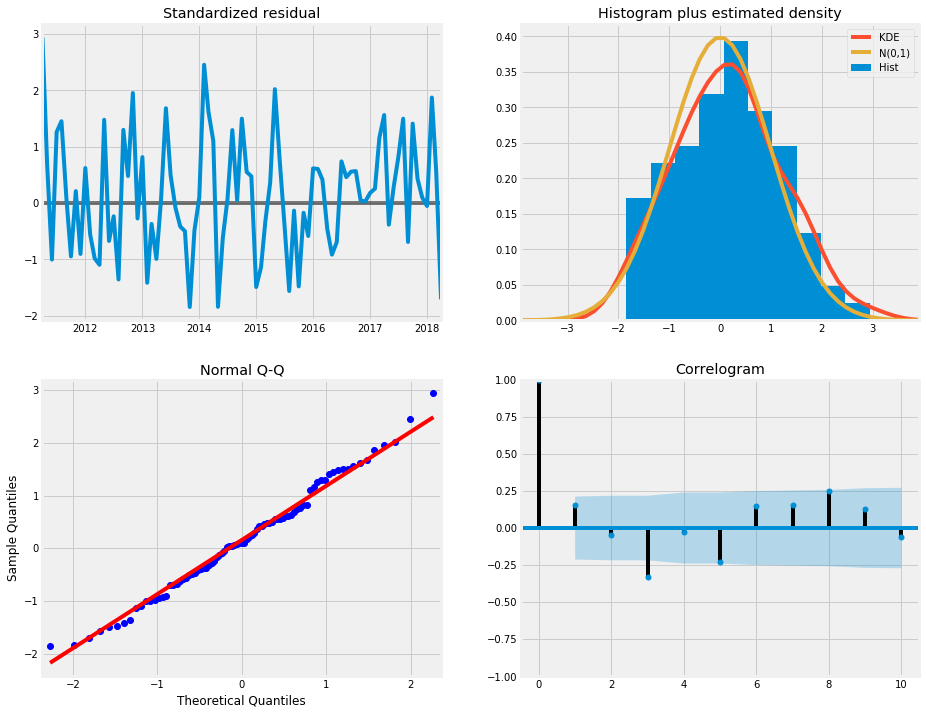

In [98]:
output.plot_diagnostics(figsize=(14,12));

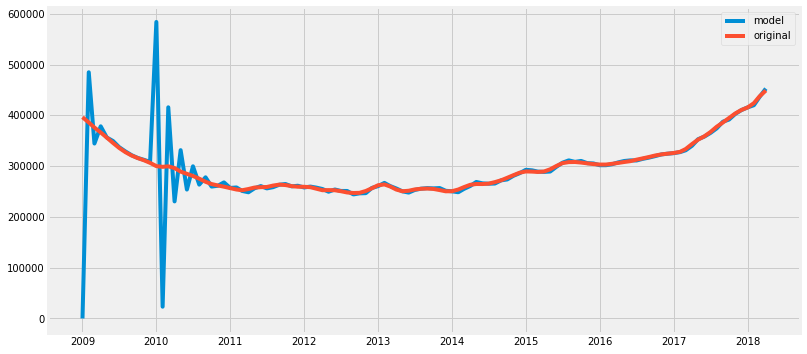

In [99]:
fig = plt.figure(figsize=(12,6))

plt.plot(output.predict(), label='model')
plt.plot(uc_ts, label='original')
plt.legend()

In [100]:
# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=60)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int(alpha=.01)


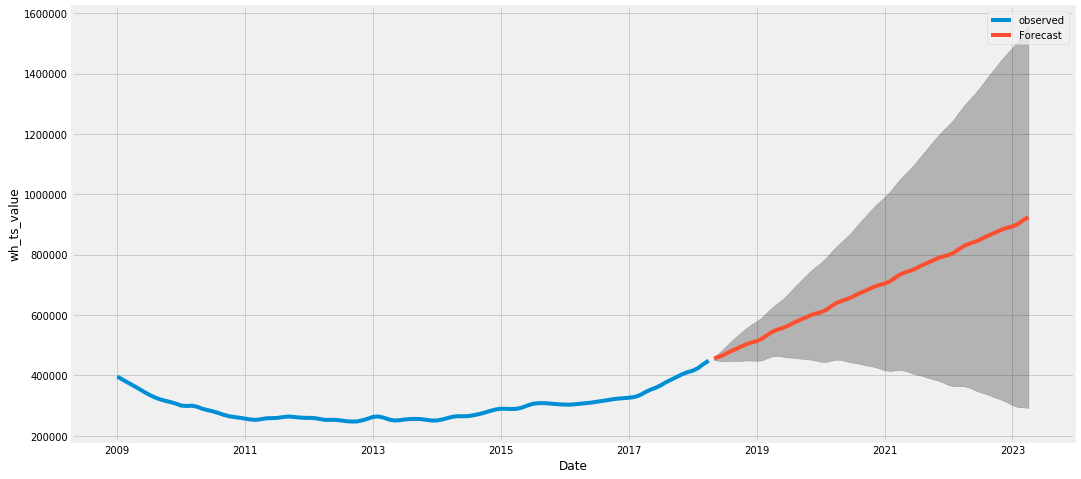

In [101]:
ax = uc_ts.plot(label='observed', figsize=(16, 8))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('wh_ts_value')

plt.legend()
plt.show()

In [102]:
SARIMA_MSE_Iterator(data=uc_ts, n_test=12, seasonal=[0,12])

[(0, 1, 1), (0, 0, 2, 0), 'ct'] 1584.4407099416721
[(0, 1, 2), (1, 0, 2, 0), 'ct'] 1710.7418798735648
[(0, 1, 0), (2, 0, 1, 0), 'ct'] 1787.2712140628823


#### Jersey City

In [104]:
SARIMA_MSE_Iterator(data=jc_ts, n_test=12, seasonal=[0,12])

[(0, 1, 1), (0, 0, 2, 12), 't'] 2811.571560609667
[(0, 1, 2), (1, 1, 1, 12), 'c'] 2892.186193035914
[(0, 1, 2), (1, 0, 1, 12), 'ct'] 2968.477348900775


#### Oakland

In [105]:
SARIMA_MSE_Iterator(data=ok_ts, n_test=12, seasonal=[0,12])

[(2, 0, 0), (2, 1, 1, 12), 'c'] 1166.4154685349204
[(0, 1, 1), (0, 0, 2, 0), 't'] 1198.627307613101
[(0, 1, 1), (2, 1, 1, 12), 'ct'] 1202.6721111403738




## Low Cost Models

In [106]:
va_ts = va_ts['value']
au_ts = au_ts['value']
lw_ts =lw_ts['value']

#### Vallejo

In [107]:
SARIMA_MSE_Iterator(data=va_ts, n_test=12, seasonal=[0,12])

[(2, 1, 0), (0, 0, 2, 0), 't'] 585.1198777725305
[(0, 1, 2), (0, 0, 2, 12), 't'] 612.9608755369834
[(1, 0, 2), (0, 0, 2, 0), 't'] 620.5065588874785


#### Aurora

In [108]:
SARIMA_MSE_Iterator(data=au_ts, n_test=12, seasonal=[0,12])

[(2, 0, 1), (1, 0, 1, 12), 'n'] 448.6105986599073
[(2, 0, 2), (1, 0, 1, 12), 't'] 480.13075893777125
[(1, 0, 0), (1, 0, 2, 0), 'n'] 533.2971667855044


#### Lake Wood

In [109]:
SARIMA_MSE_Iterator(data=lw_ts, n_test=12, seasonal=[0,12])

[(1, 0, 2), (2, 0, 0, 12), 'ct'] 490.61862163307904
[(0, 1, 1), (2, 0, 2, 12), 'ct'] 524.3138716754319
[(0, 1, 2), (0, 1, 0, 12), 't'] 545.9231119955433


# Parking Lot

In [ ]:
# tester = top_low_ts['Williston_58801']
# tester['pct_pct1'] = tester['YoY_change'].diff(periods=3)
# tester['pct_pct2'] = tester['YoY_change'].diff(periods=6)
# tester.head(15)

In [ ]:
# tester.pct_pct1.plot(label='6_period')
# tester.pct_pct2.plot(label='3_period')
# # tester.YoY_change.plot(label='YoY')
# plt.legend()

In [ ]:
# t = list(top_high_cities.city_zipcode)
# t 

In [ ]:
# t_df = melt_data(top_high_cities[top_high_cities['city_zipcode'] == t[0]])

# t_df.head()

In [ ]:
# def get_time_series(list_of_cities, df):
#     time_series_dfs = {}
#     for c in list_of_cities:
#         time_series_dfs[c] = melt_data(df[df['city_zipcode'] == c])
    
#     return time_series_dfs

In [ ]:
# list_test = get_time_series(t, top_high_cities)
# list_test['New York_11233'].plot(label='New_York_11233')
# plt.title('New_York_11233')

In [ ]:
# for c in t:
#     list_test[c].plot()
#     plt.title(c)
#     plt.show()

In [ ]:
# n_test = 12
# cfg_list = sarima_configs(seasonal=[0])
# scores = grid_search(sj_ts, cfg_list, n_test)
# print('done')
# for cfg, error in scores[:3]:
#         print(cfg, error)

done

[(0, 1, 0), (1, 0, 1, 0), 'ct'] 1612.076147366579

[(1, 0, 0), (2, 0, 1, 0), 't'] 1798.8762823948903

[(1, 0, 1), (2, 0, 0, 0), 't'] 1803.1913541129268